# **Menon Labs: Spotify Initial Data Analysis**

## **Collaborators** 
- Ashna Sood 
- Shubhum Agrawal
- Shania Sinha
- Sergio Vazquez
- Rohil Khatkhate
- Kerrn Reehal

## **Imports**

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.metrics import classification_report, precision_recall_fscore_support, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import metrics

from google.colab import drive

In [ ]:
# upload a kaggle api key and set it to be used
from google.colab import files

files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# use the kaggle api to download the dataset we'll be using
!kaggle datasets download -d yamaerenay/spotify-dataset-19212020-160k-tracks
!unzip spotify-dataset-19212020-160k-tracks.zip

 99% 193M/195M [00:08<00:00, 19.4MB/s]
100% 195M/195M [00:08<00:00, 25.3MB/s]
Archive:  spotify-dataset-19212020-160k-tracks.zip
  inflating: artists.csv             
  inflating: data_by_artist_o.csv    
  inflating: data_by_genres_o.csv    
  inflating: data_by_year_o.csv      
  inflating: data_o.csv              
  inflating: dict_artists.json       
  inflating: tracks.csv              


## **Data Wrangling**

In [ ]:
# read in audio features for around 600k tracks 
data = pd.read_csv('tracks.csv', index_col='id')
data

,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
id,,,,,,,,,,,,,,,,,,,
35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3
021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1
07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5
08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3
08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4
0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4
27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4


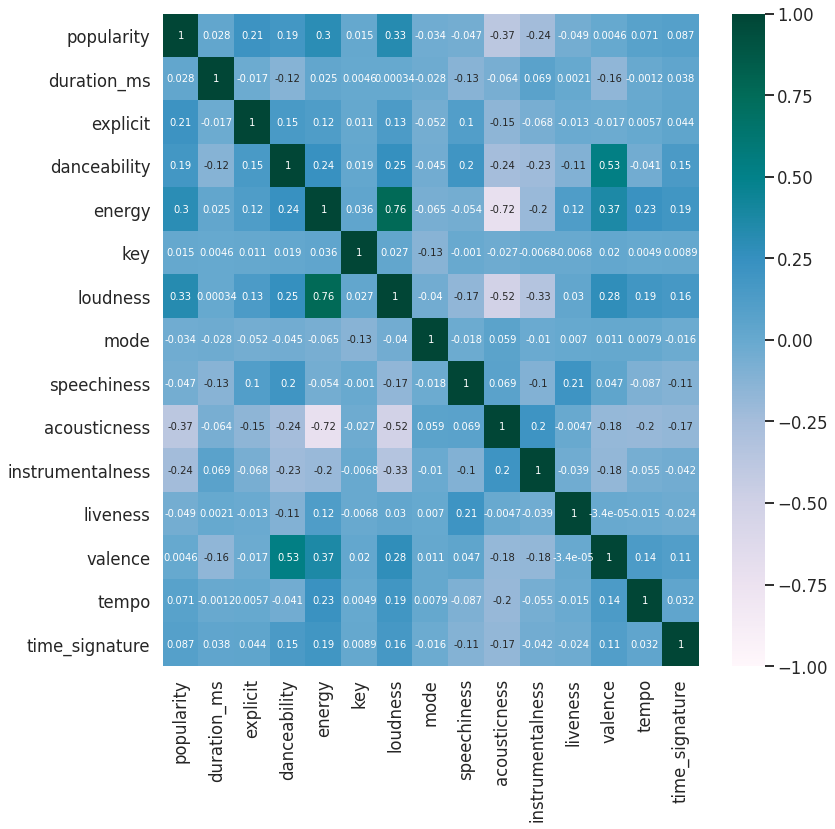

In [ ]:
# calculate correlations between audio features
tracks_corrs = data.corr()
# visualize correlation matrix in a heatmap to easily depict the highly correlated audio features
plt.figure(figsize=(12, 12))
sns.heatmap(tracks_corrs, annot=True, vmin=-1.0, cmap='PuBuGn')
plt.show()

In [ ]:
# scale both the loudness and tempo to normalize the range of all audio features between [0, 1]
data['loudness_scaled'] = StandardScaler().fit_transform(data[['loudness']])
data['tempo_scaled'] = StandardScaler().fit_transform(data[['tempo']])
data

,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,loudness_scaled,tempo_scaled
id,,,,,,,,,,,,,,,,,,,,,
35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3,-0.615393,-0.457392
021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1,-2.344110,-0.552876
07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,-2.156266,0.401596
08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,-3.488663,1.730782
08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,-1.315289,-0.512190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,0.537413,0.451253
0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,0.979122,1.062561
27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,-0.514201,0.894707


In [ ]:
# remove duplicate songs present in the df 
data = data.drop_duplicates(subset=['name', 'artists'], keep='first')
data

,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,loudness_scaled,tempo_scaled
id,,,,,,,,,,,,,,,,,,,,,
35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3,-0.615393,-0.457392
021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1,-2.344110,-0.552876
07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,-2.156266,0.401596
08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,-3.488663,1.730782
08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,-1.315289,-0.512190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,0.537413,0.451253
0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,0.979122,1.062561
27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,-0.514201,0.894707


In [ ]:
# only keep songs that are from 1970s and onwards -- for initial clustering experiments (14, 15, 16) kept songs from 1950s onwards, but decreased ultimately range
data['release_date'] = pd.to_datetime(data['release_date'])
min_date = pd.to_datetime('1/1/1970')
data = data.loc[(data['release_date'] >= min_date)]
data

,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,loudness_scaled,tempo_scaled
id,,,,,,,,,,,,,,,,,,,,,
6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,56,160187,0,['Gerry & The Pacemakers'],['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.484,0.265,0,-11.101,1,0.0322,0.394,0.000000,0.1490,0.2850,113.564,3,-0.175845,-0.164657
6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,['The Toys'],['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,2,-2.706,1,0.0571,0.436,0.000000,0.1390,0.8390,120.689,4,1.473686,0.074726
4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,40,141987,0,['Gerry & The Pacemakers'],['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.405,0.365,6,-10.226,0,0.0289,0.255,0.000005,0.1630,0.5880,104.536,4,-0.003917,-0.467975
0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,34,157093,0,['Gerry & The Pacemakers'],['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.477,0.352,1,-14.165,1,0.0300,0.406,0.000000,0.1220,0.4780,106.773,4,-0.777890,-0.392818
1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,26,187333,0,['Frank Sinatra'],['1Mxqyy3pSjf8kZZL4QVxS0'],2018-05-04,0.319,0.201,7,-17.796,1,0.0623,0.887,0.000000,0.9040,0.2390,117.153,3,-1.491344,-0.044075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.518,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,0.537413,0.451253
0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.663,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,0.979122,1.062561
27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.314,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,-0.514201,0.894707


In [ ]:
# remove podcasts and audiobooks - 0.83 is a good cutoff that songs that are primarily rap are not excluded
data = data.loc[(data['speechiness'] < 0.83)]
data

,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,loudness_scaled,tempo_scaled
id,,,,,,,,,,,,,,,,,,,,,
6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,56,160187,0,['Gerry & The Pacemakers'],['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.484,0.265,0,-11.101,1,0.0322,0.394,0.000000,0.1490,0.2850,113.564,3,-0.175845,-0.164657
6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,['The Toys'],['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,2,-2.706,1,0.0571,0.436,0.000000,0.1390,0.8390,120.689,4,1.473686,0.074726
4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,40,141987,0,['Gerry & The Pacemakers'],['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.405,0.365,6,-10.226,0,0.0289,0.255,0.000005,0.1630,0.5880,104.536,4,-0.003917,-0.467975
0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,34,157093,0,['Gerry & The Pacemakers'],['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.477,0.352,1,-14.165,1,0.0300,0.406,0.000000,0.1220,0.4780,106.773,4,-0.777890,-0.392818
1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,26,187333,0,['Frank Sinatra'],['1Mxqyy3pSjf8kZZL4QVxS0'],2018-05-04,0.319,0.201,7,-17.796,1,0.0623,0.887,0.000000,0.9040,0.2390,117.153,3,-1.491344,-0.044075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.518,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,0.537413,0.451253
0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.663,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,0.979122,1.062561
27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.314,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,-0.514201,0.894707


In [ ]:
# remove tracks outside of time bounds
data = data.loc[(data['duration_ms'] >= 30*1000)]
data = data.loc[(data['duration_ms'] <= 10*60*1000)]
data

,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,loudness_scaled,tempo_scaled
id,,,,,,,,,,,,,,,,,,,,,
6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,56,160187,0,['Gerry & The Pacemakers'],['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.484,0.265,0,-11.101,1,0.0322,0.394,0.000000,0.1490,0.2850,113.564,3,-0.175845,-0.164657
6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,['The Toys'],['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,2,-2.706,1,0.0571,0.436,0.000000,0.1390,0.8390,120.689,4,1.473686,0.074726
4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,40,141987,0,['Gerry & The Pacemakers'],['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.405,0.365,6,-10.226,0,0.0289,0.255,0.000005,0.1630,0.5880,104.536,4,-0.003917,-0.467975
0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,34,157093,0,['Gerry & The Pacemakers'],['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.477,0.352,1,-14.165,1,0.0300,0.406,0.000000,0.1220,0.4780,106.773,4,-0.777890,-0.392818
1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,26,187333,0,['Frank Sinatra'],['1Mxqyy3pSjf8kZZL4QVxS0'],2018-05-04,0.319,0.201,7,-17.796,1,0.0623,0.887,0.000000,0.9040,0.2390,117.153,3,-1.491344,-0.044075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.518,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,0.537413,0.451253
0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.663,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,0.979122,1.062561
27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.314,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,-0.514201,0.894707


In [ ]:
# 400,497 songs now in the dataset 
# reduce to key audio features for input into the ML model
input_data = data[['acousticness', 'danceability', 'energy', 'valence', 
                   'loudness_scaled', 'tempo_scaled']]
input_data

,acousticness,danceability,energy,valence,loudness_scaled,tempo_scaled
id,,,,,,
6catF1lDhNTjjGa2GxRQNN,0.394,0.484,0.265,0.2850,-0.175845,-0.164657
6Pkt6qVikqPBt9bEQy8iTz,0.436,0.671,0.867,0.8390,1.473686,0.074726
4aSw1QJIMwYSoDEgzgdCJL,0.255,0.405,0.365,0.5880,-0.003917,-0.467975
0ZMMtH875IR2TfkyC4PolD,0.406,0.477,0.352,0.4780,-0.777890,-0.392818
1hx7X9cMXHWJjknb9O6Ava,0.887,0.319,0.201,0.2390,-1.491344,-0.044075
...,...,...,...,...,...,...
5rgu12WBIHQtvej2MdHSH0,0.785,0.560,0.518,0.2110,0.537413,0.451253
0NuWgxEp51CutD2pJoF4OM,0.141,0.765,0.663,0.6860,0.979122,1.062561
27Y1N4Q4U3EfDU5Ubw8ws2,0.895,0.535,0.314,0.0663,-0.514201,0.894707


## **K Means Clustering Analysis**

In [ ]:
# initial exploration of K-Means Clustering to create the different emotion song clusters 
def kmeans_sse(k):
  km = KMeans(n_clusters=k)
  print(f'fitting for k={k}')
  km = km.fit(input_data)
  print('completed\n')
  # SSE of distance to closest cluster center
  return km.inertia_

sse = [kmeans_sse(k) for k in range(1, 25)]

fitting for k=1
completed

fitting for k=2
completed

fitting for k=3
completed

fitting for k=4
completed

fitting for k=5
completed

fitting for k=6
completed

fitting for k=7
completed

fitting for k=8
completed

fitting for k=9
completed

fitting for k=10
completed

fitting for k=11
completed

fitting for k=12
completed

fitting for k=13
completed

fitting for k=14
completed

fitting for k=15
completed

fitting for k=16
completed

fitting for k=17
completed

fitting for k=18
completed

fitting for k=19
completed

fitting for k=20
completed

fitting for k=21
completed

fitting for k=22
completed

fitting for k=23
completed

fitting for k=24
completed



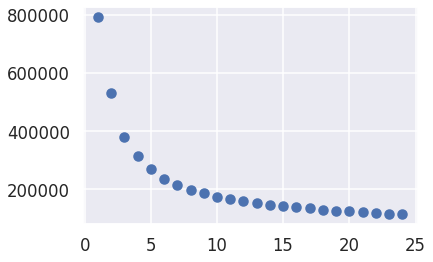

In [ ]:
# plot to see which number of clusters performs relatively the best
plt.scatter(range(1, 25), sse)

After observing that a minimum of 14-15 clusters would begin to better separate out the songs into various emotion clusters, we explored a deeper analysis of higher k values, ultimately choosing to create 30 clusters. 

In [ ]:
# perform K means clustering to create K clusters
def kmeans_predict(k):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(input_data)m
  return kmeans.predict(input_data)

In [ ]:
# return important data from each cluster
def songs_from_cluster(c=None):
  if c or c == 0:
    display_data = data[data['cluster'] == c] 
  else:
    display_data = data 
  display_data.sort_values(by=['popularity', 'release_date'], 
                           ascending=[False, False], inplace=True)
  display_data = display_data[['name', 'artists', 'acousticness',
                   'danceability', 'energy', 'instrumentalness',
                   'liveness', 'speechiness', 'valence', 
                   'loudness', 'tempo']]
  
  return display_data

# display histogram and means of quantitative data and the 25 most popular songs
def display_info_cluster(c=None):
  df = songs_from_cluster(c)
  print('-'*20 + f'cluster {c}' + '-'*20)
  print(f'n={len(df.index)}')
  df.hist(sharey=True, layout=(1, 9), figsize=(20, 5))
  plt.show()
  return df.head(25)

In [ ]:
# code to output csv files to drive 
def output_to_drive(labeled_data, folder_name):
  """ Create a folder in My Drive with the given name using given data

      Folder contains:
        - summary text file with number of songs in each cluster
        - histograms for each cluster
        - csv of all songs in each cluster, sorted by popularity and release date
  """
  # create folder
  drive.mount('/content/drive')
  basepath = '/content/drive/My Drive/' + folder_name + '/'
  os.mkdir(basepath)

  # calculate number of clusters
  num_clusters = max(labeled_data['cluster'].unique()) + 1

  with open(basepath+'summary.txt', 'w') as summ_file:
    # summary file header
    summ_file.write(f'{num_clusters} clusters\n')
    summ_file.write('-'*20+'\n')

    df_all = songs_from_cluster()
    df_all.to_csv(basepath+'all_songs.csv')

    for c in range(num_clusters):
      df = songs_from_cluster(c)
      summ_file.write(f'cluster {c}: {len(df.index)} songs\n')
      df.hist(sharey=True, layout=(1, 11), figsize=(20, 5))
      plt.savefig(basepath+f'histograms_{c}')
      df.to_csv(basepath+f'songs_{c}.csv')
      
  # save to drive
  drive.flush_and_unmount()

In [ ]:
# 14 clusters
y_kmeans14 = kmeans_predict(14)
data['cluster'] = y_kmeans14
data

,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,loudness_scaled,tempo_scaled,cluster
id,,,,,,,,,,,,,,,,,,,,,,
5RcvlmVx2xtFcp2Ta5pw7X,Someone To Watch Over Me,57,196667,0,['Ella Fitzgerald'],['5V0MlUE1Bft0mbLlND7FJz'],1950-09-11,0.354,0.0851,7,-13.738,1,0.0345,0.990,0.000004,0.1230,0.1970,97.684,1,-0.693989,-0.698186,6
5DIVWgTeJ2fPIxaY9e7ZKn,I've Got A Crush On You,56,196440,0,['Ella Fitzgerald'],['5V0MlUE1Bft0mbLlND7FJz'],1950-09-11,0.455,0.1060,2,-14.086,1,0.0422,0.986,0.000000,0.1220,0.2580,66.807,4,-0.762367,-1.735577,6
50AnCqAVXt8qR1RJtGudUU,Camino de Guanajuato,55,184533,0,['José Alfredo Jimenez'],['2T06whb4s6UiufL1j5Qtz9'],1950-01-01,0.572,0.4720,4,-7.359,1,0.0314,0.834,0.000002,0.1660,0.7830,94.826,4,0.559419,-0.794207,2
0VX8ptOQhUt1SIOHYLZGNN,Stardust,48,146347,0,['Hoagy Carmichael'],['7j8I1aIBA9Z9bMy7mTwWKk'],1950-01-01,0.658,0.0542,8,-19.427,1,0.0596,0.960,0.106000,0.1060,0.3450,90.138,4,-1.811819,-0.951713,5
2aCmTIqpOduPWwsRQ6t4iD,Ella,46,166173,0,['José Alfredo Jimenez'],['2T06whb4s6UiufL1j5Qtz9'],1950-01-01,0.665,0.4850,7,-6.586,1,0.0456,0.832,0.000106,0.4260,0.9380,99.449,4,0.711306,-0.638886,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,0.537413,0.451253,4
0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,0.979122,1.062561,7
27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,-0.514201,0.894707,9


Mounted at /content/drive


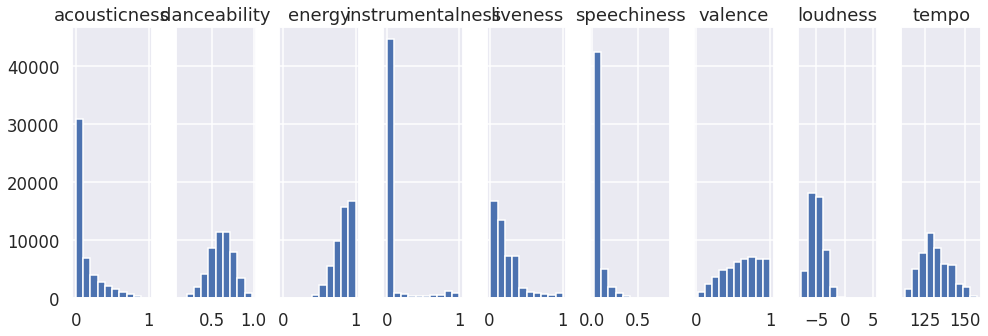

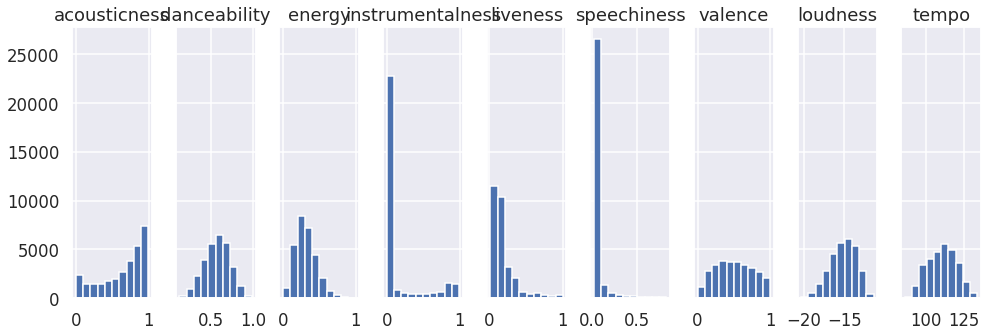

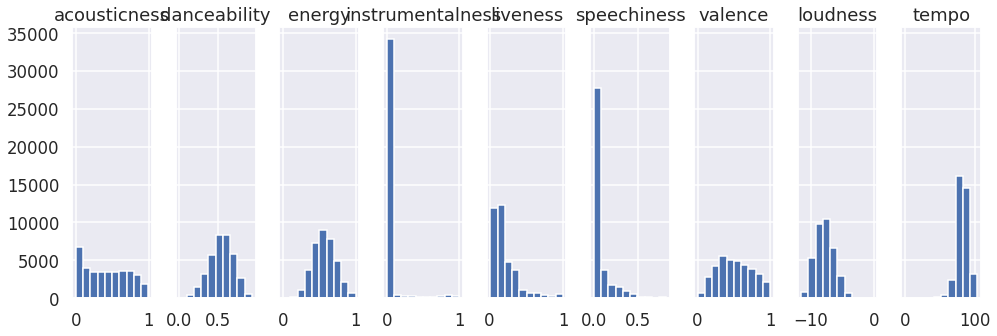

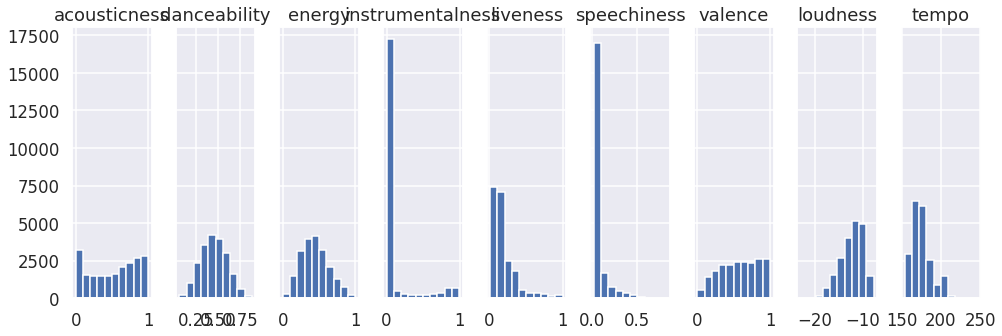

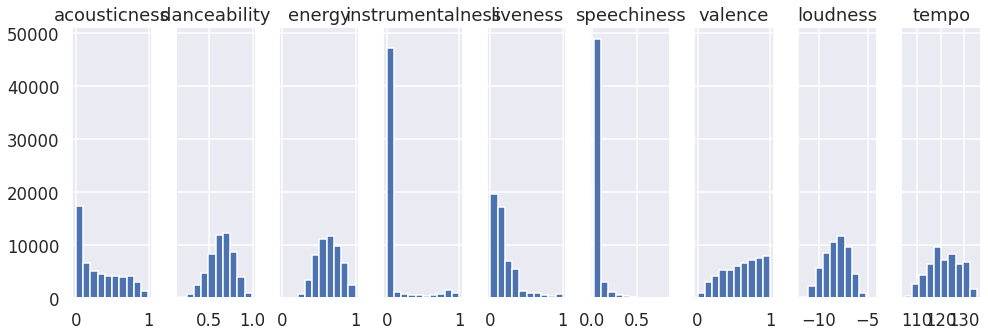

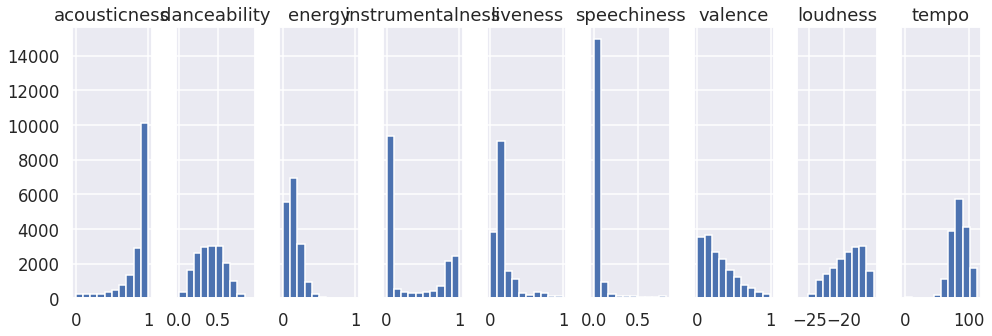

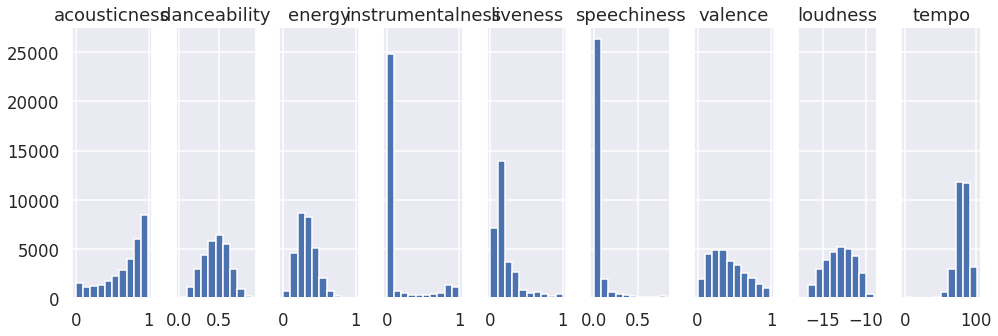

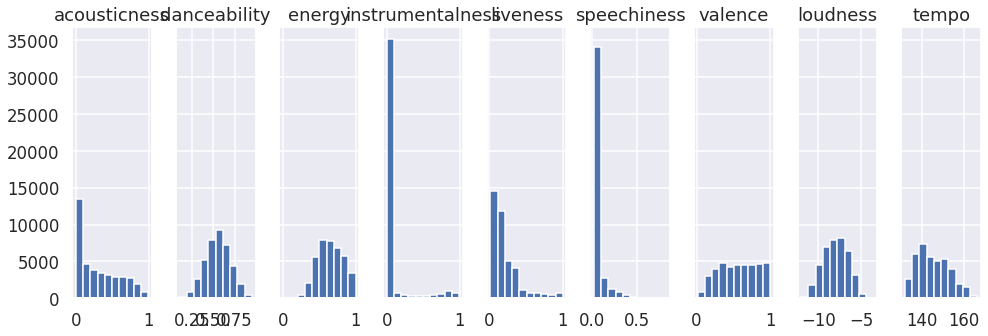

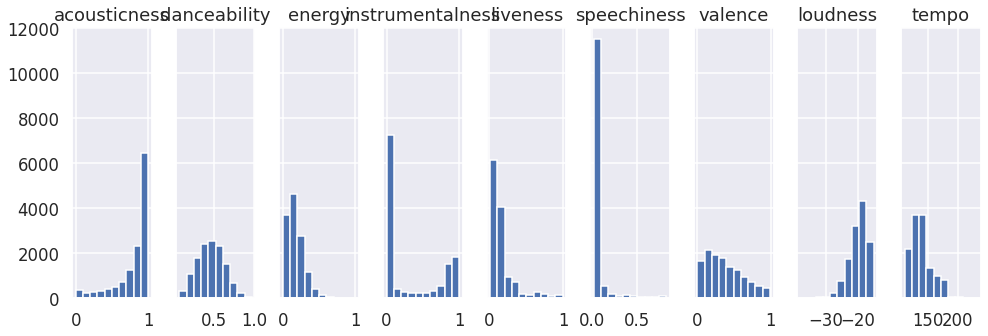

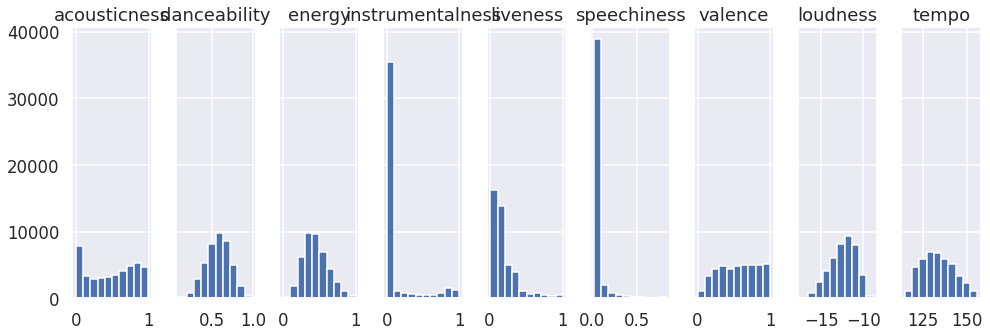

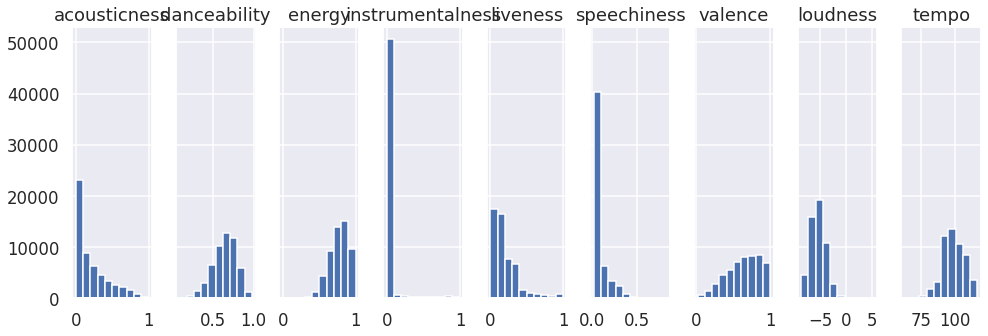

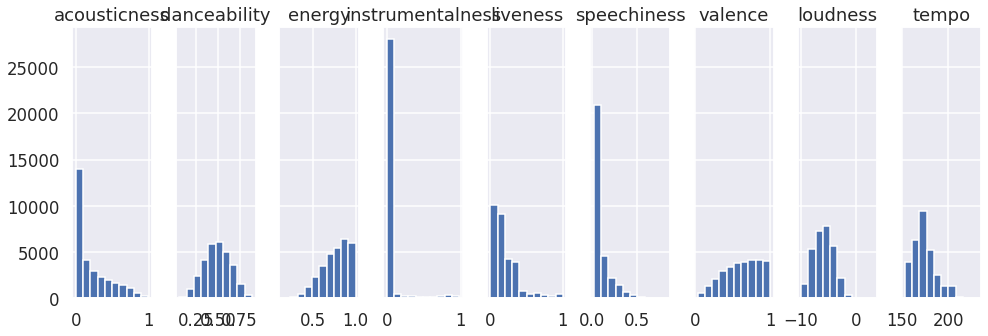

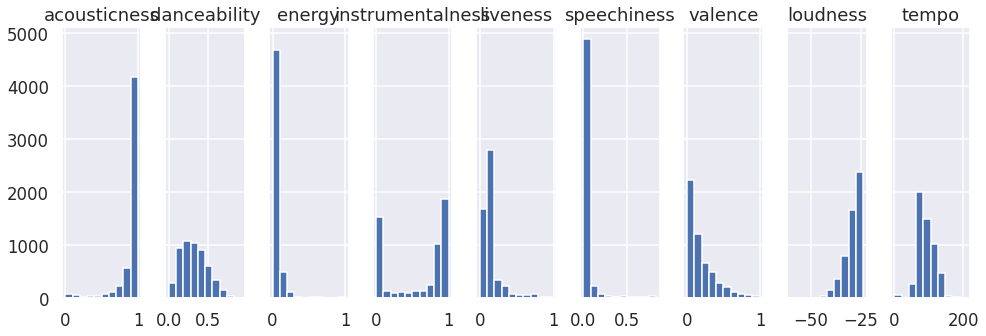

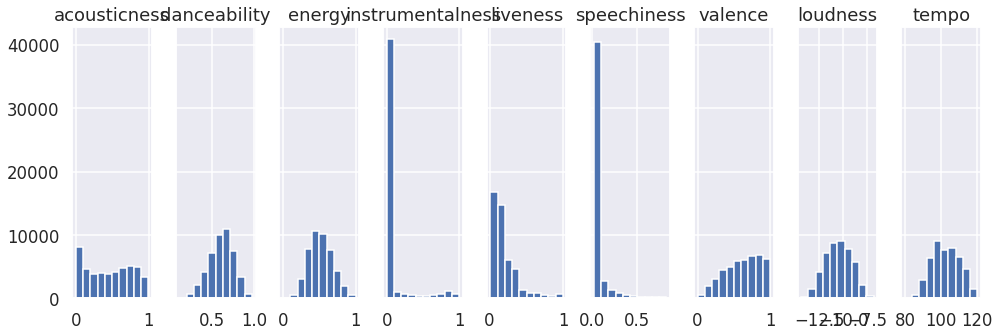

In [ ]:
# 14 clusters -- performed on songs from 1950's onwards
output_to_drive(data, 'new_data_14')

Mounted at /content/drive


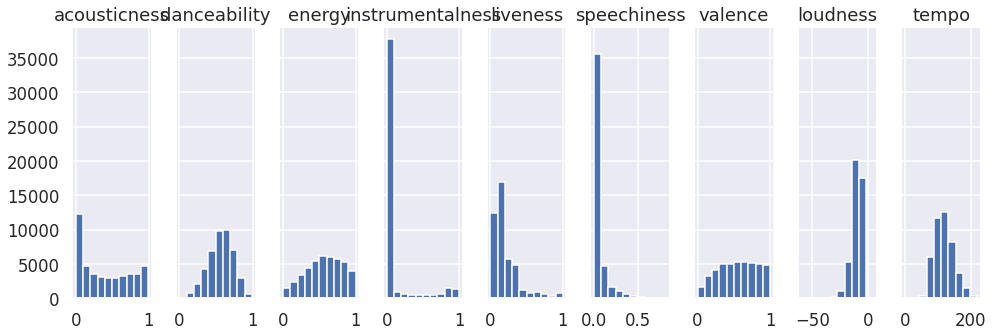

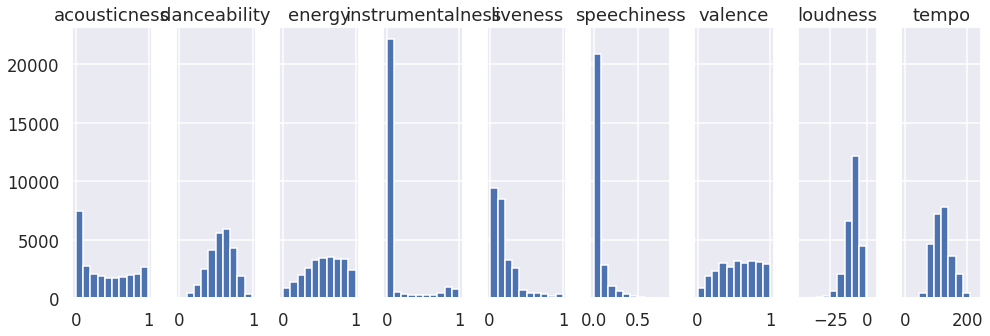

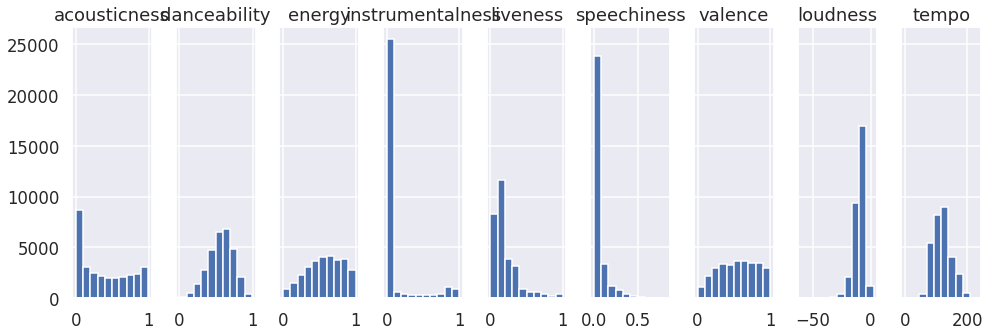

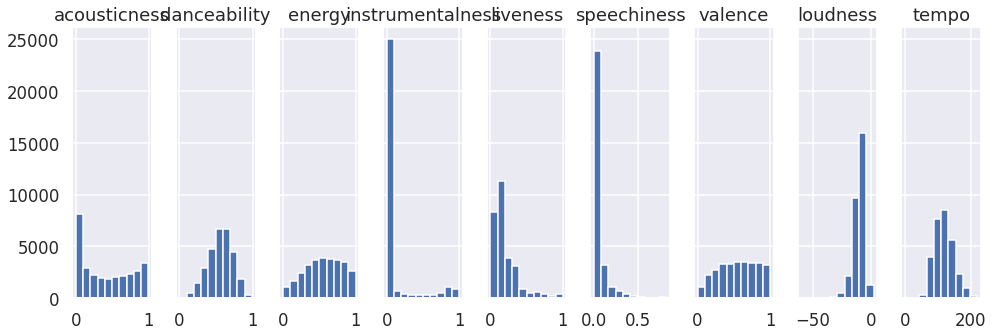

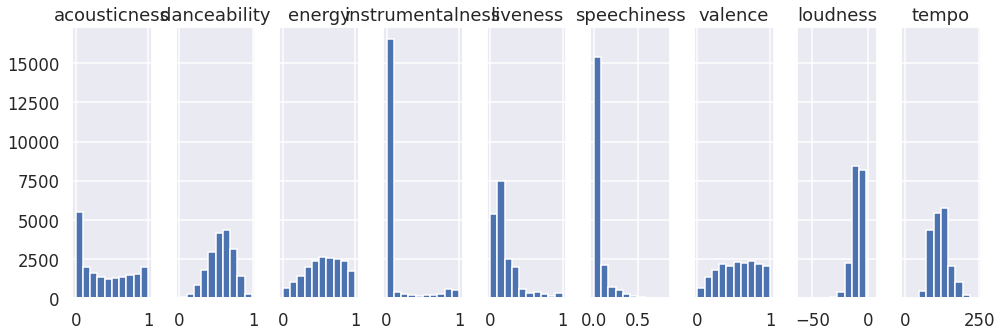

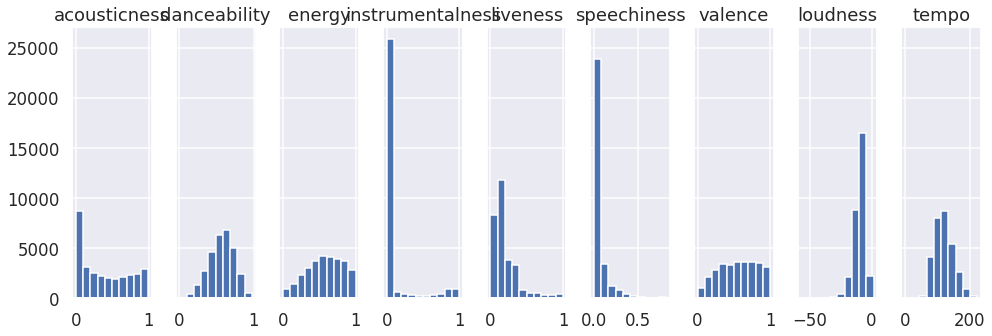

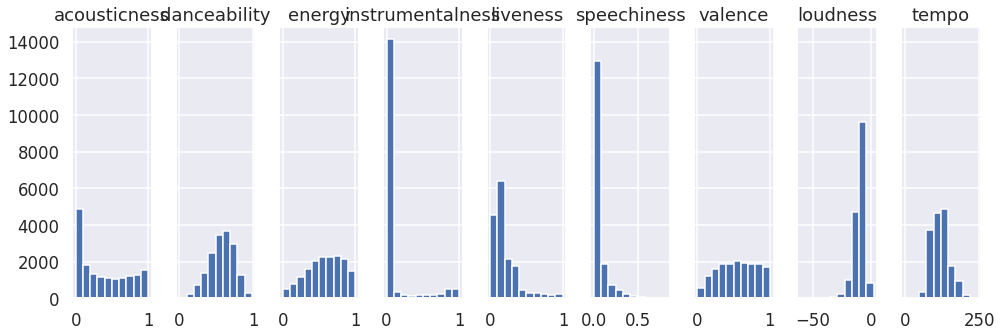

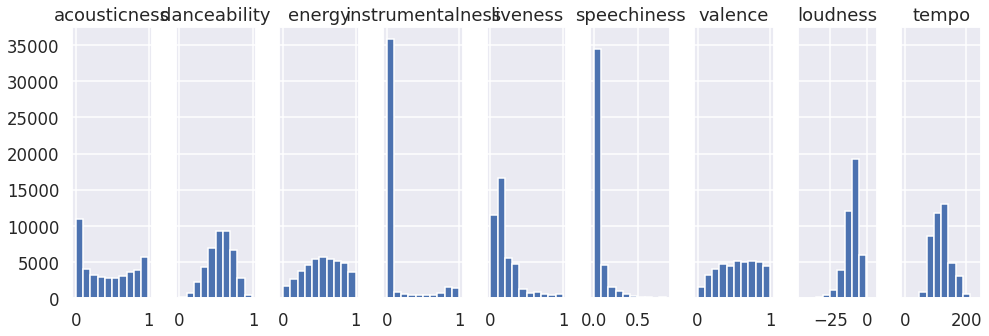

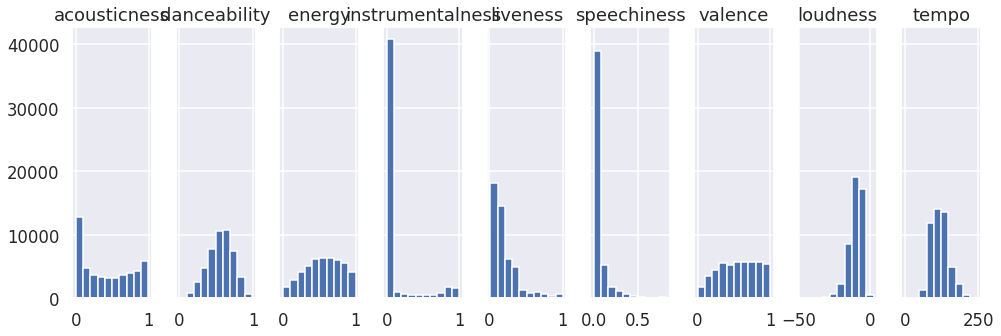

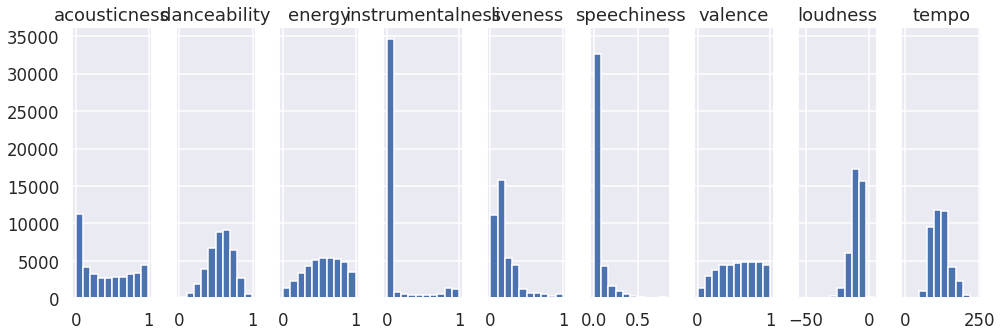

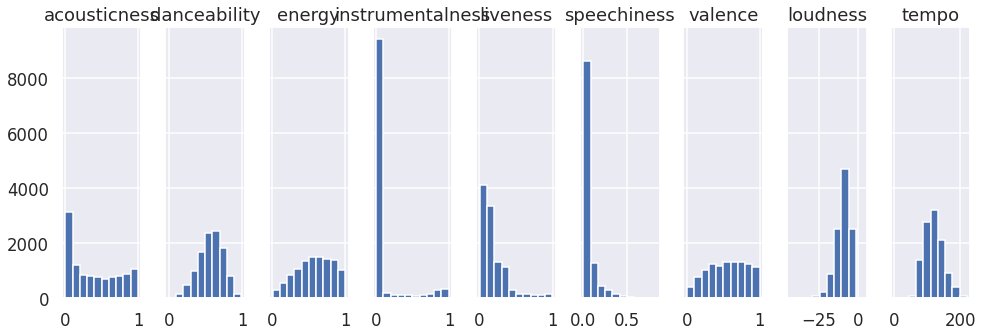

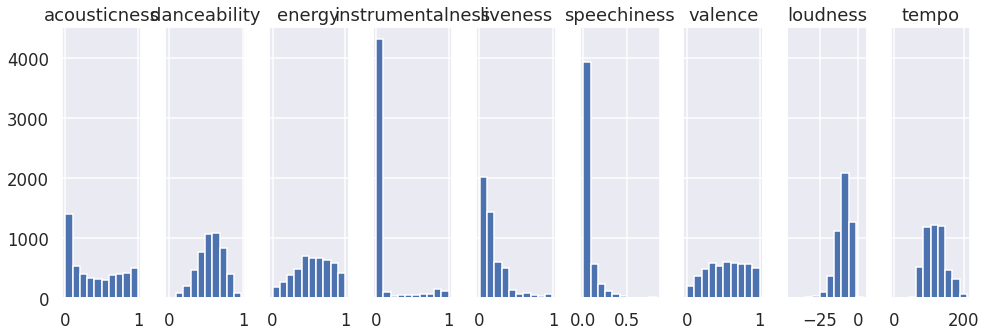

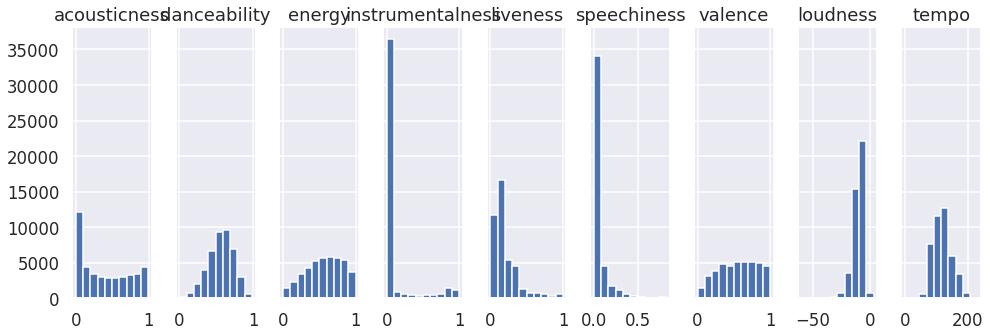

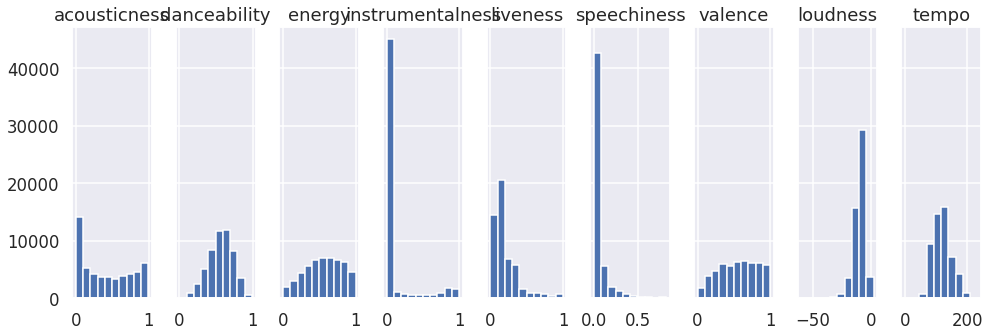

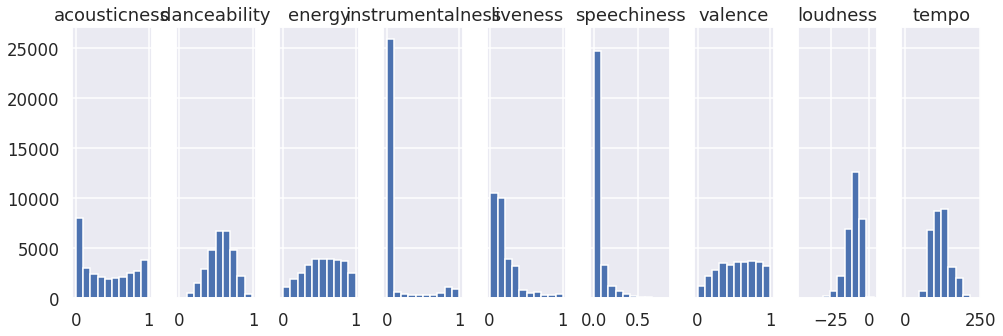

In [ ]:
# 15 clusters -- performed on songs from 1950's onwards 
y_kmeans15 = kmeans_predict(15)
data['cluster'] = y_kmeans15
output_to_drive(data, 'new_data_15')

Mounted at /content/drive


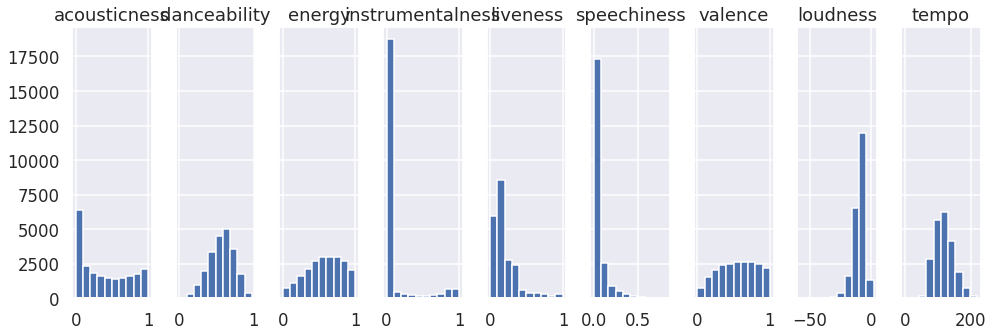

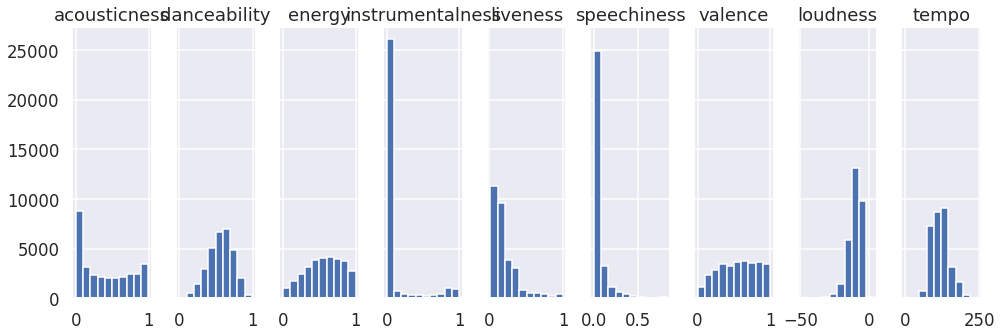

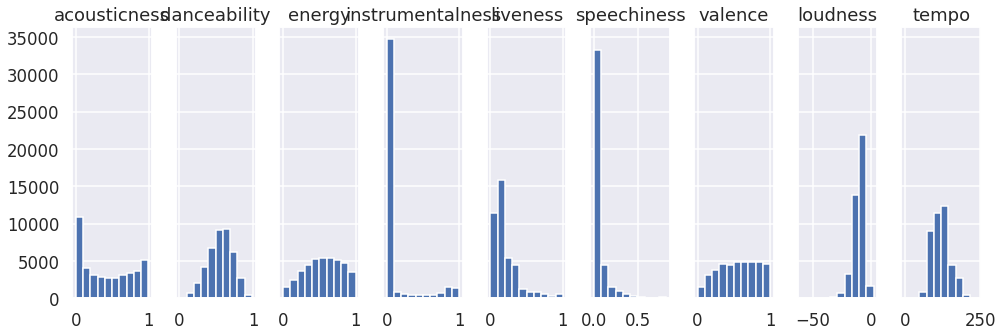

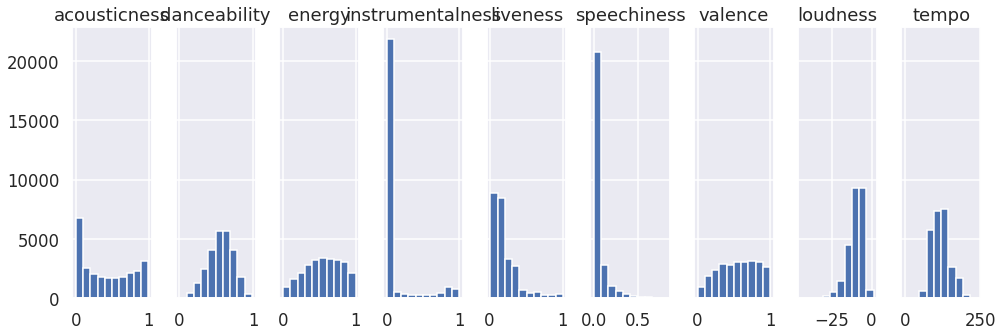

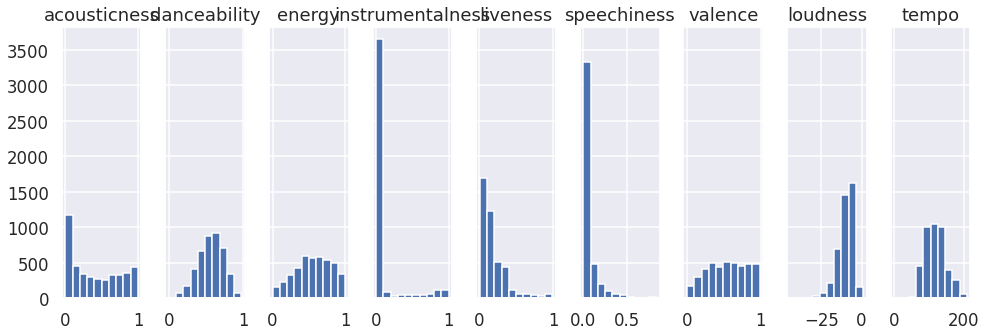

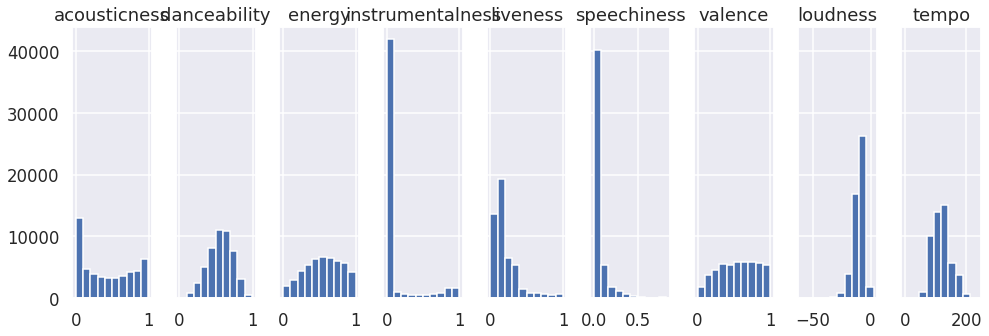

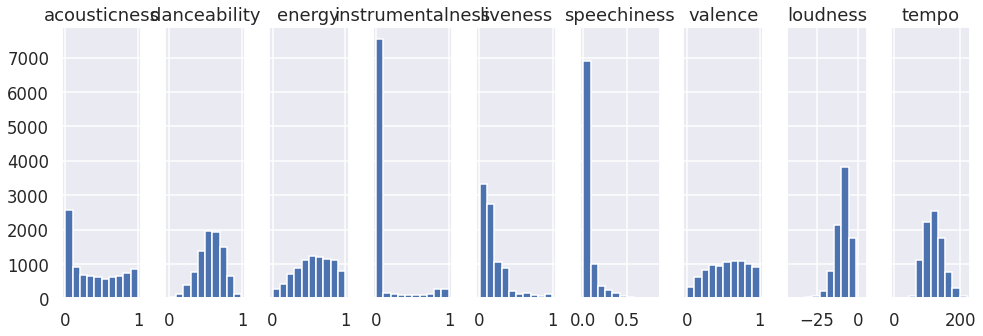

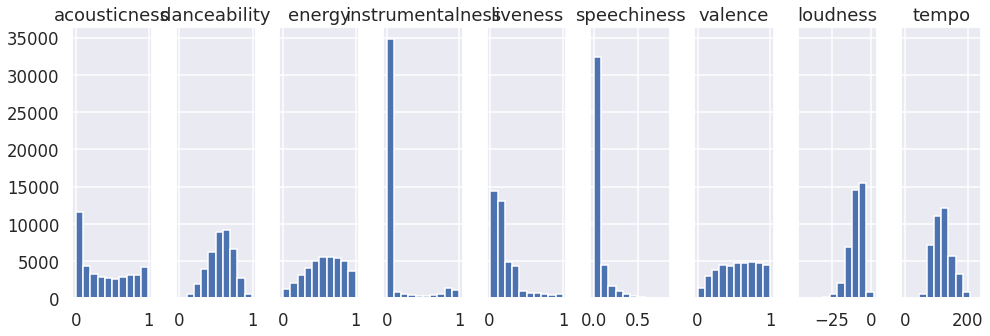

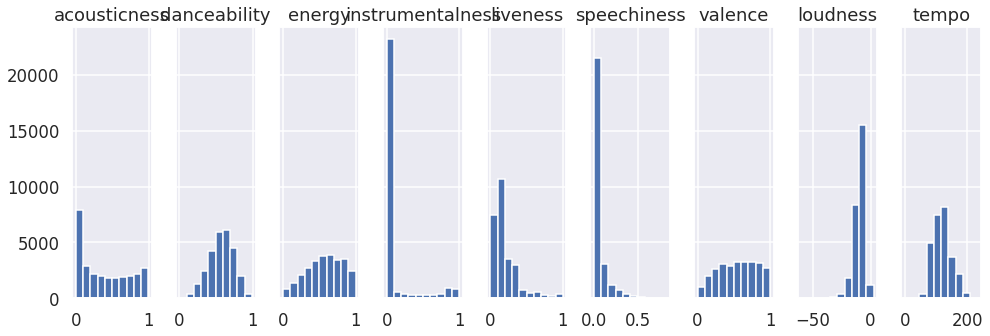

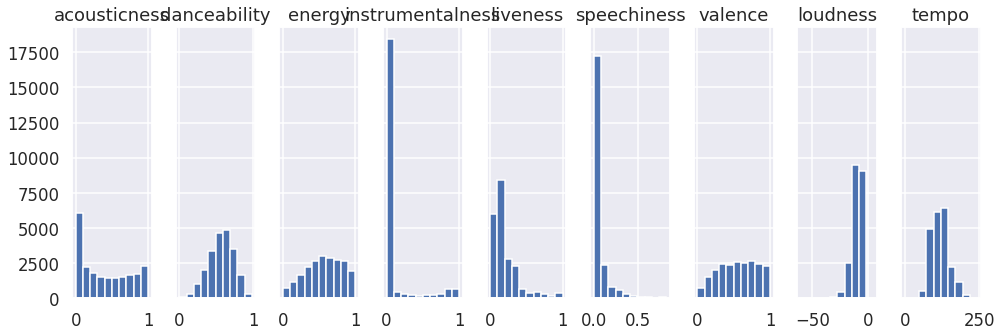

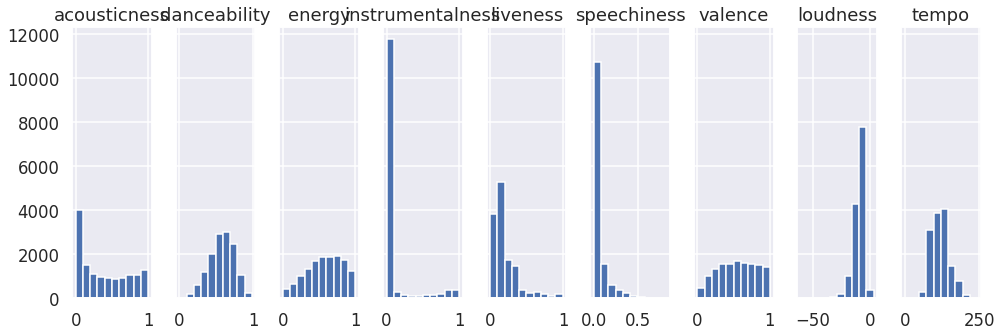

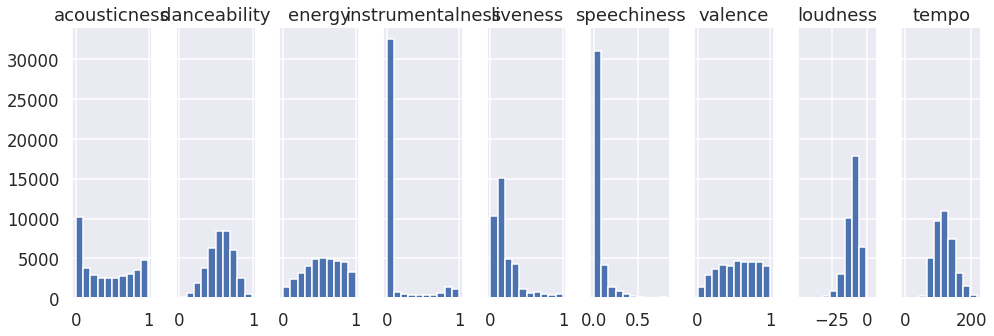

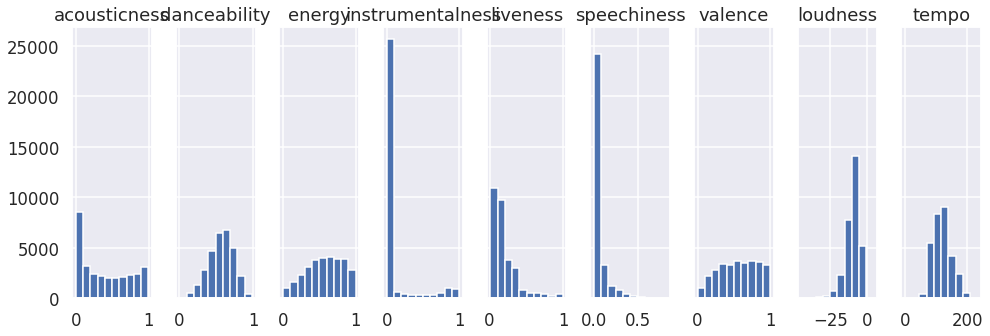

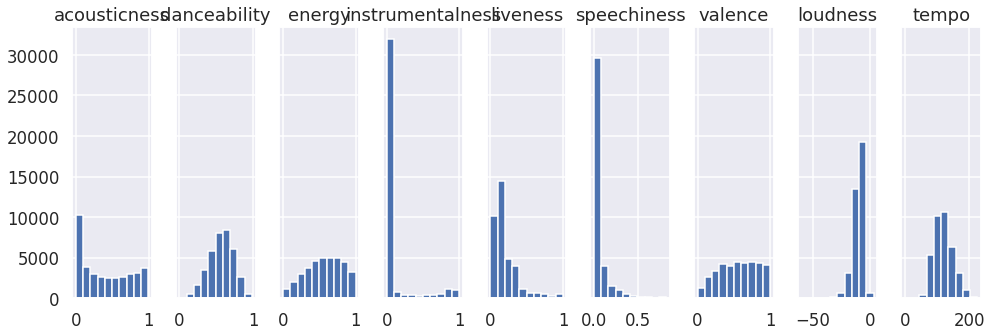

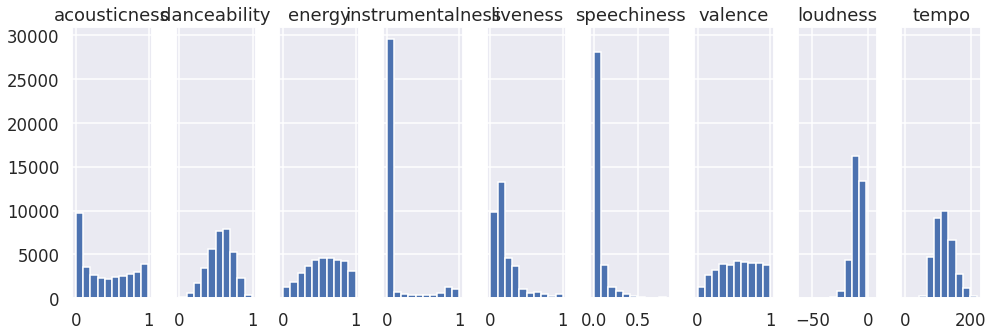

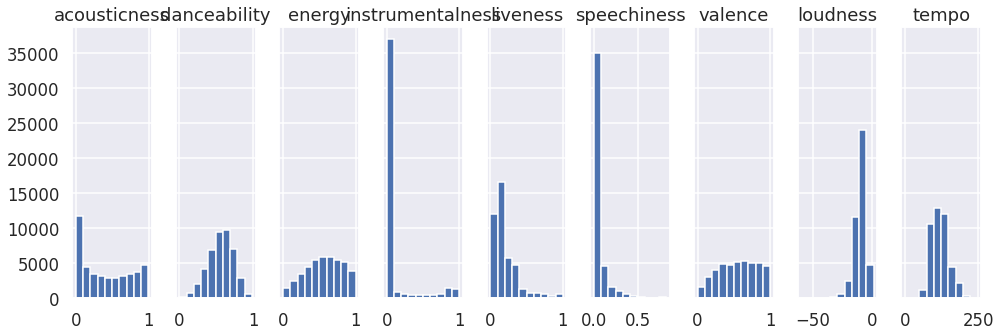

In [ ]:
# 16 clusters -- performed on songs from 1950's onwards
y_kmeans16 = kmeans_predict(16)
data['cluster'] = y_kmeans16
output_to_drive(data, 'new_data_16')

Mounted at /content/drive


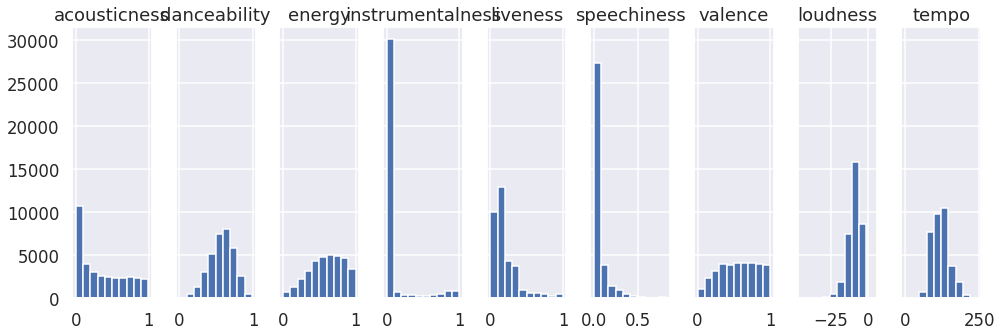

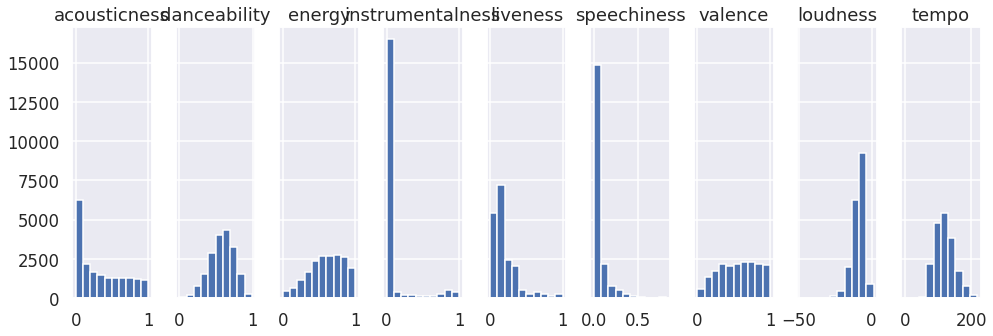

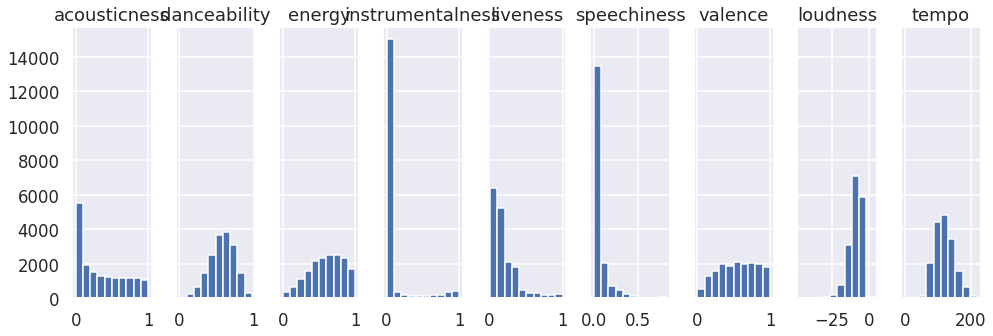

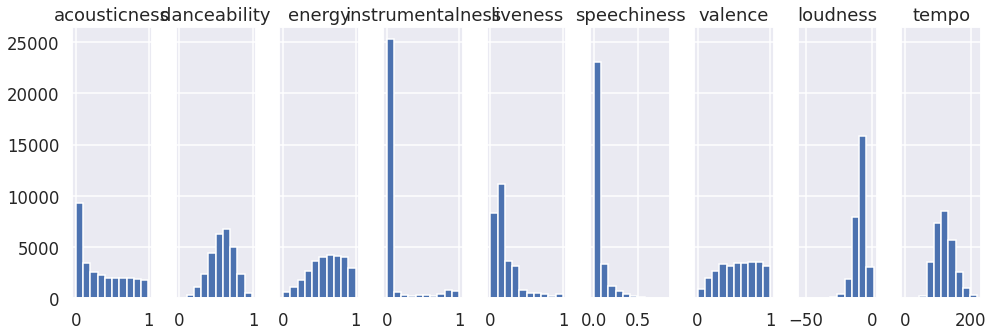

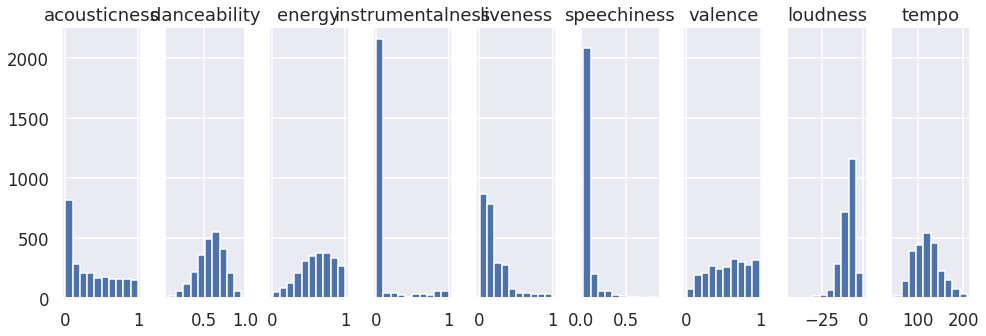

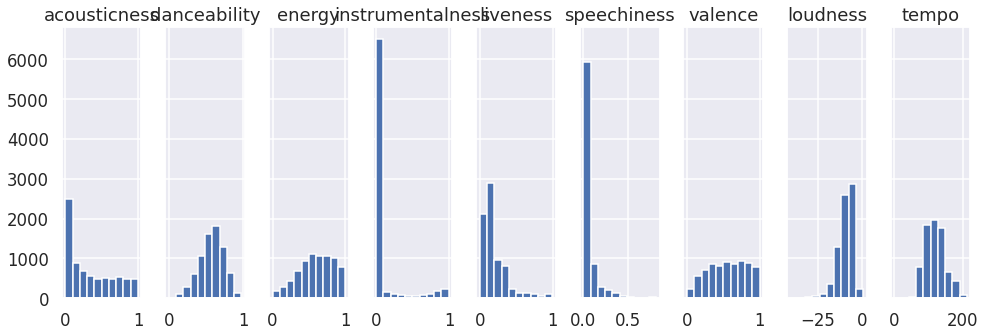

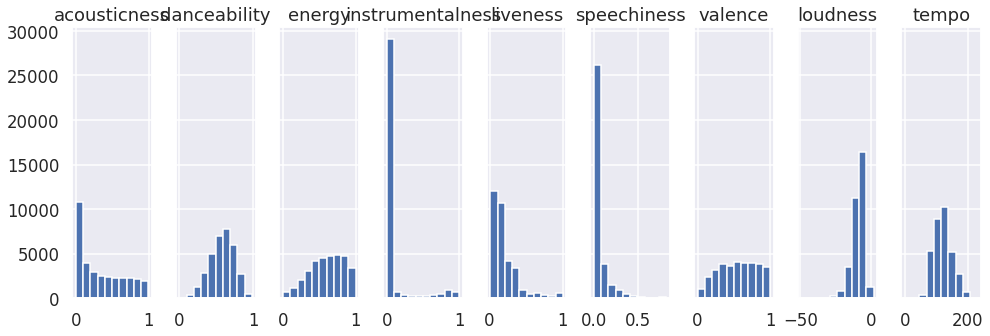

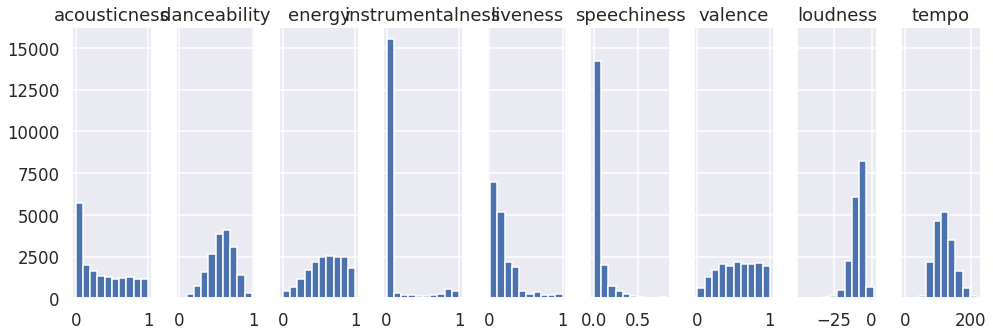

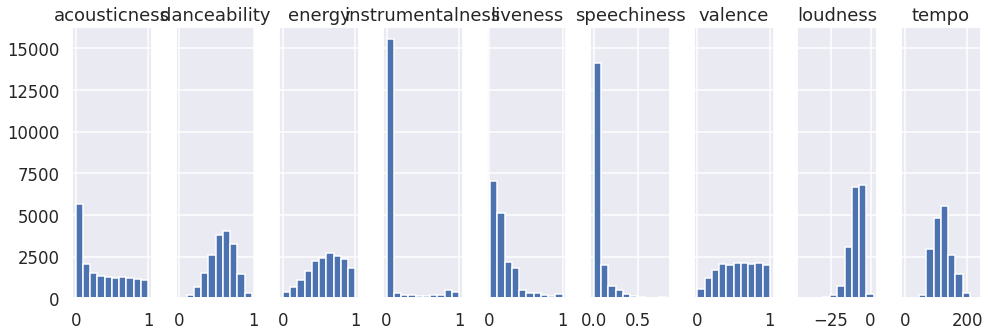

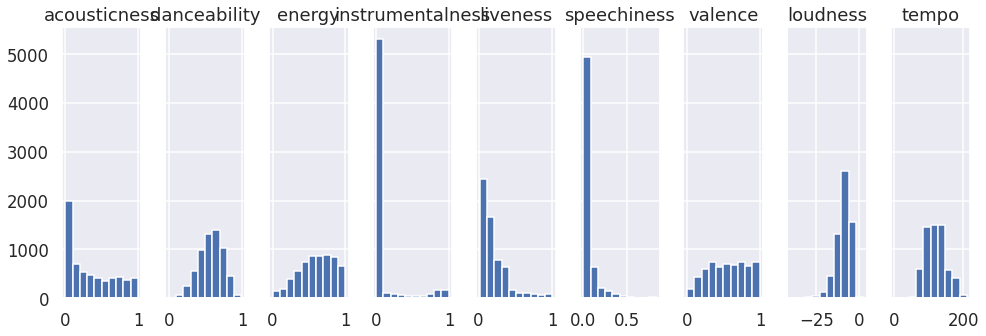

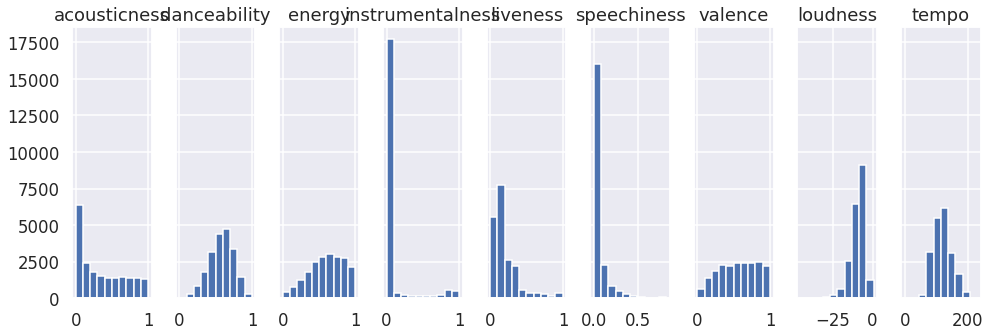

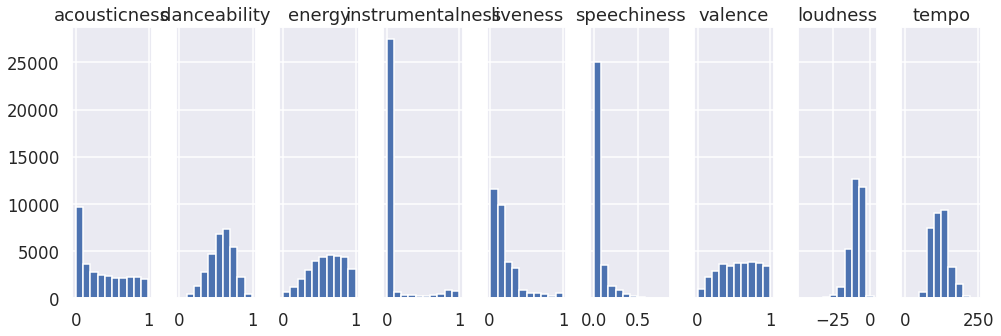

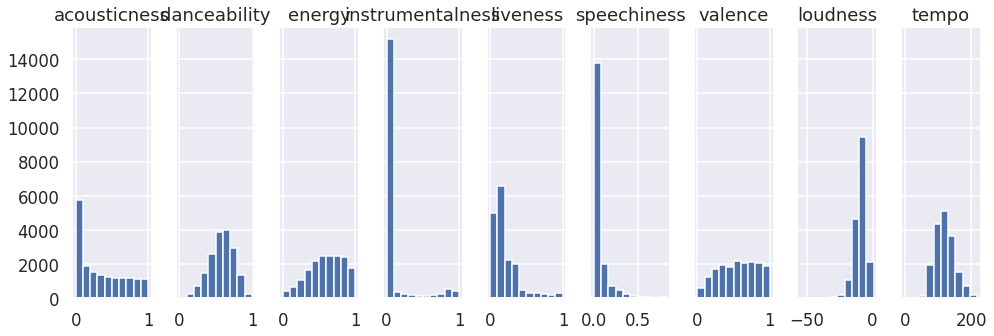

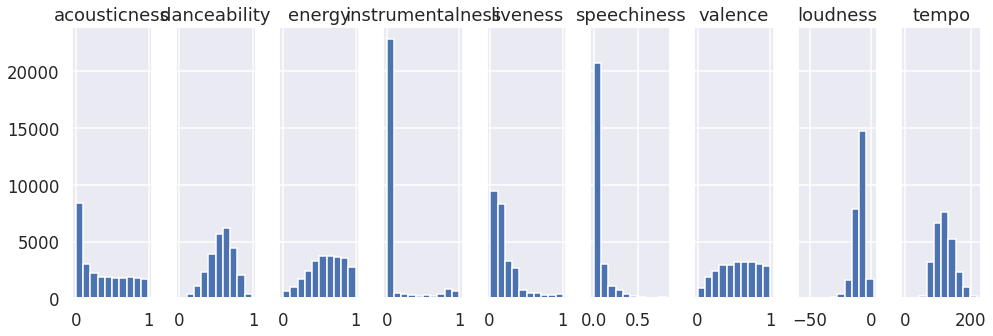

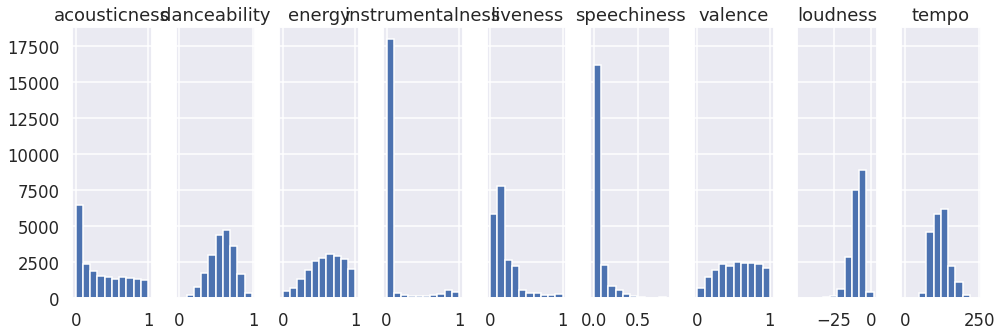

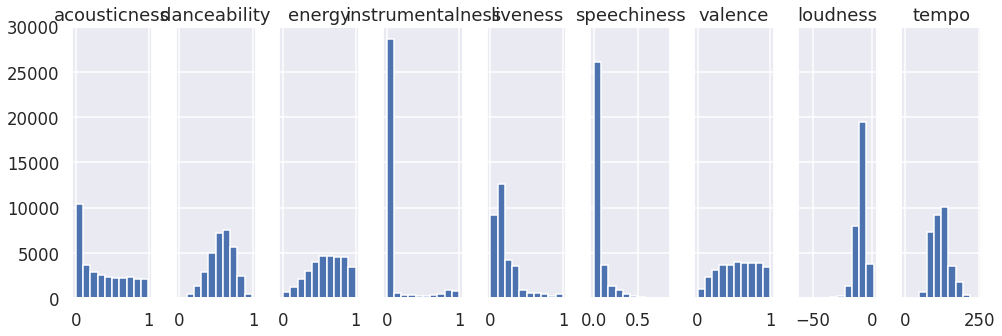

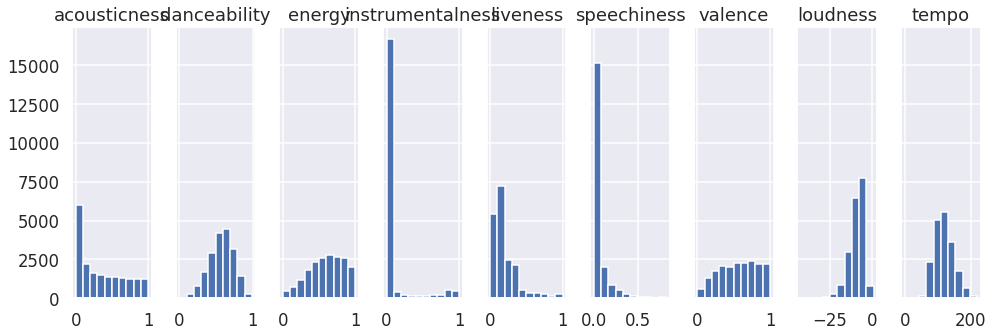

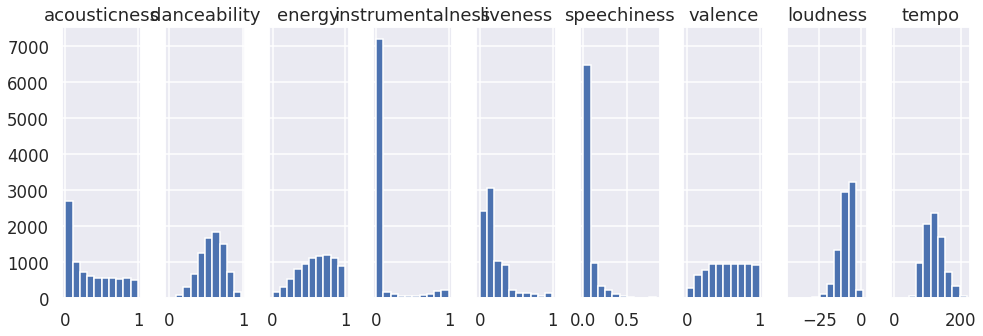

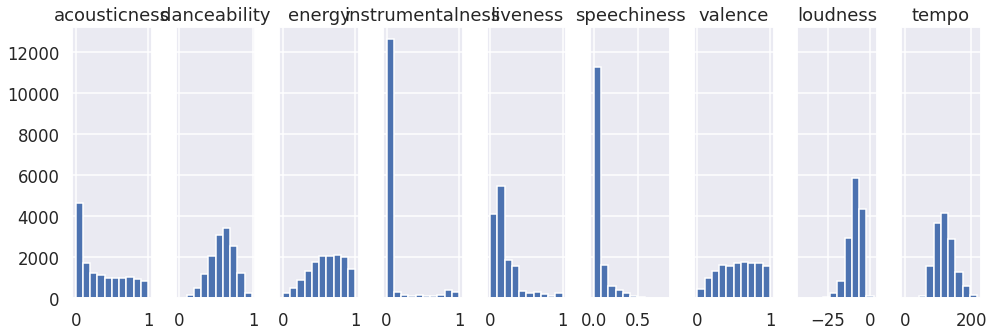

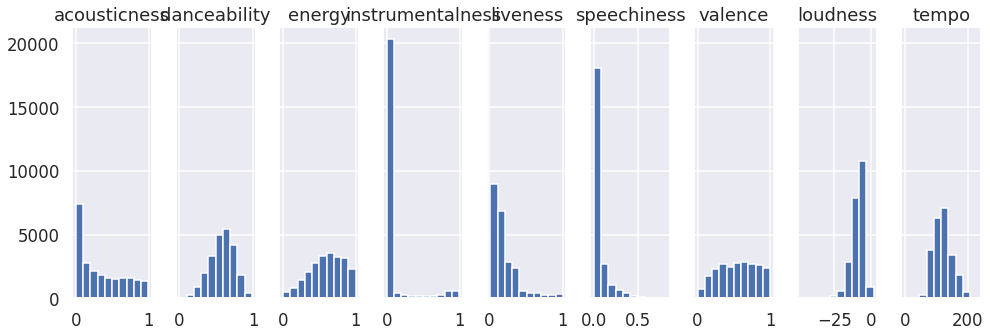

In [ ]:
# 20 clusters -- on only songs from 1970s onwards
y_kmeans20 = kmeans_predict(20)
data['cluster'] = y_kmeans20
output_to_drive(data, 'new_data_20')

Mounted at /content/drive


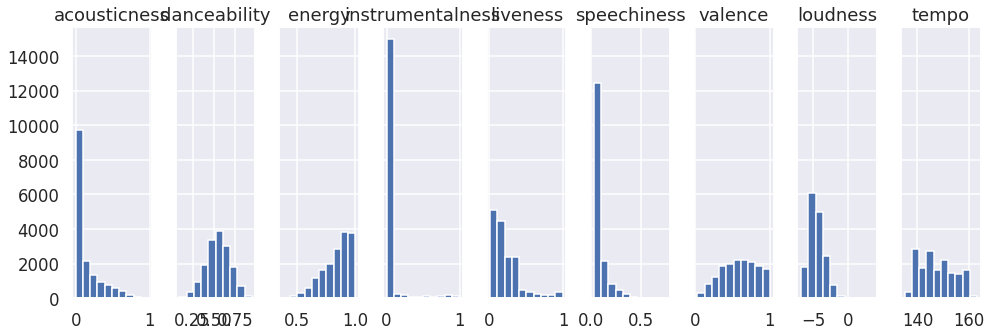

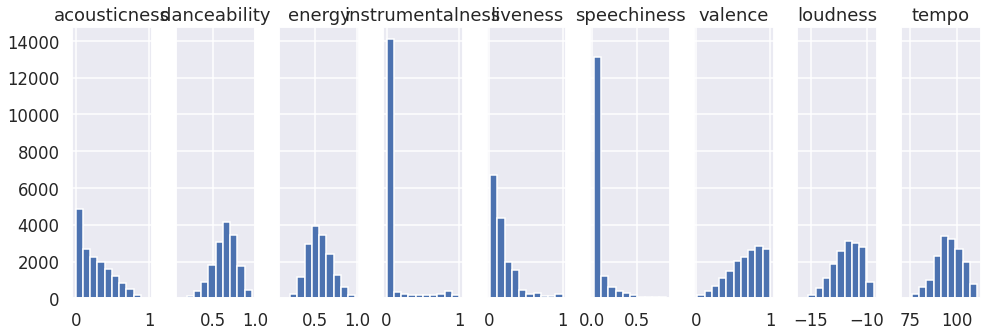

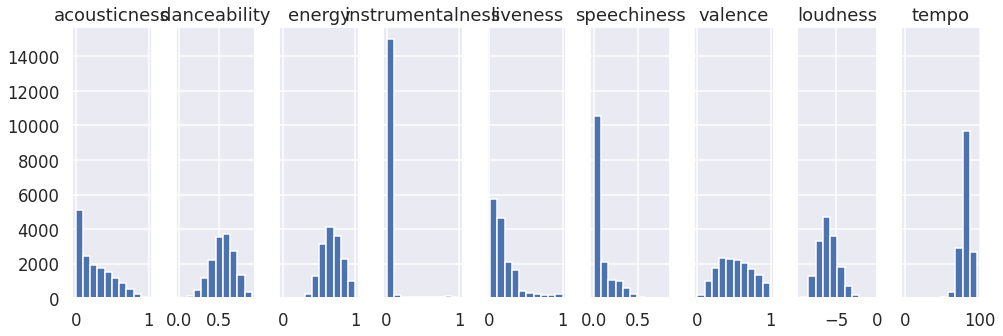

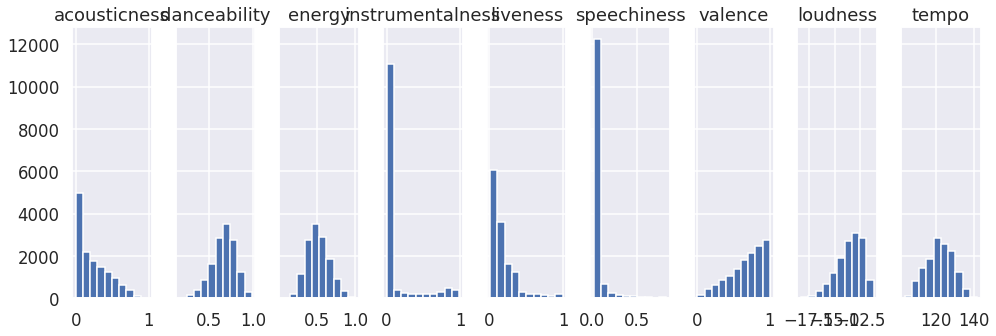

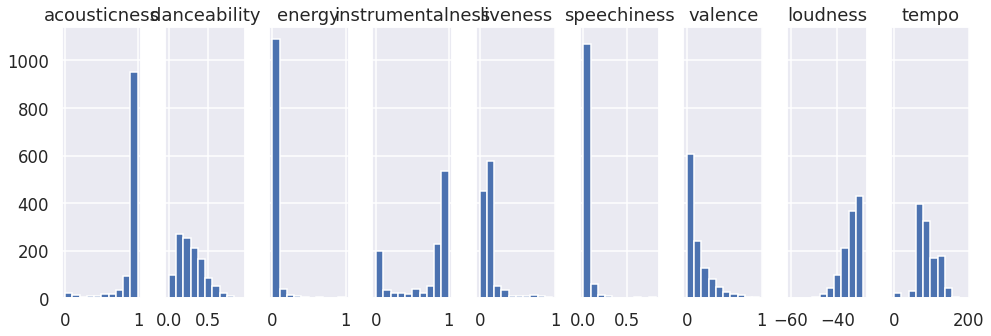

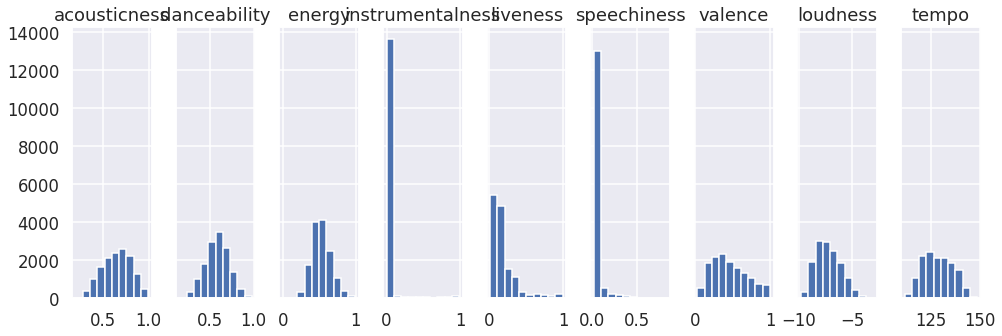

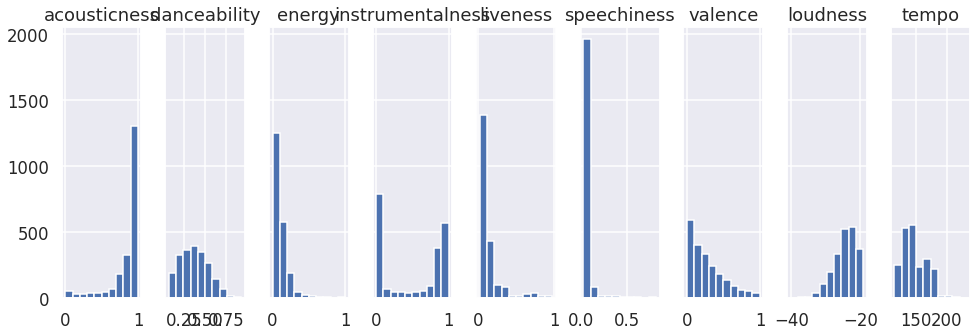

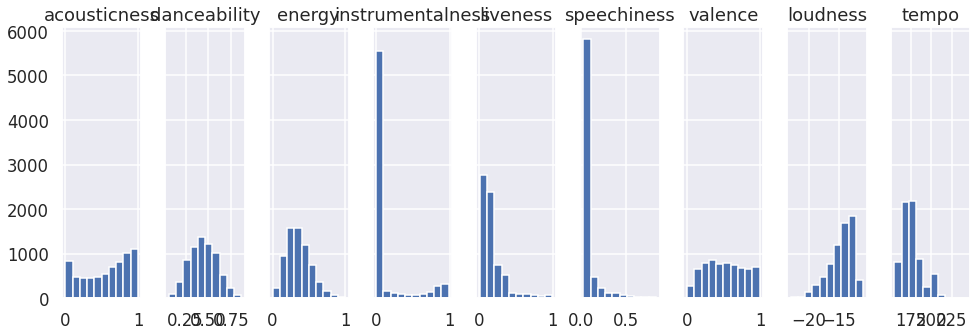

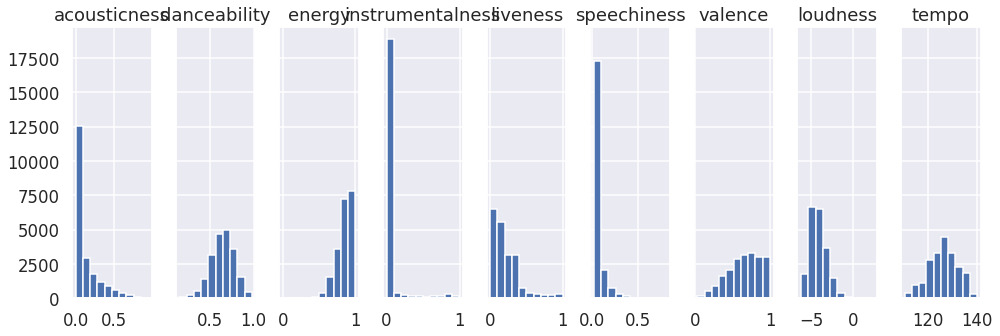

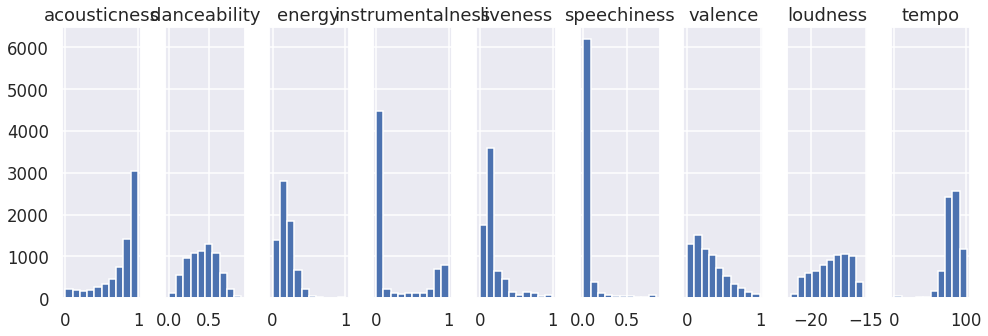

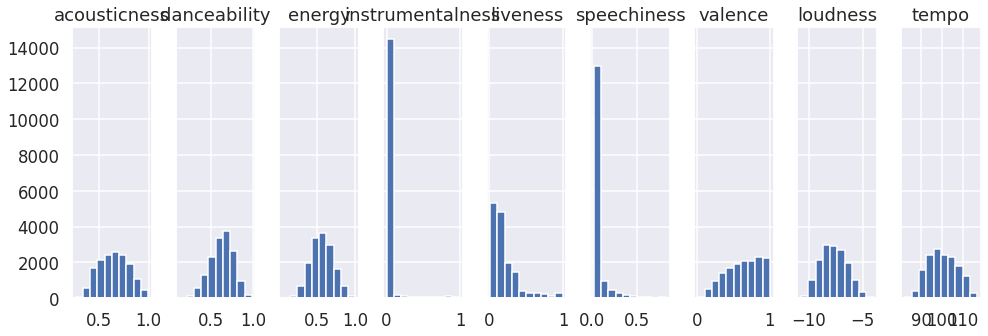

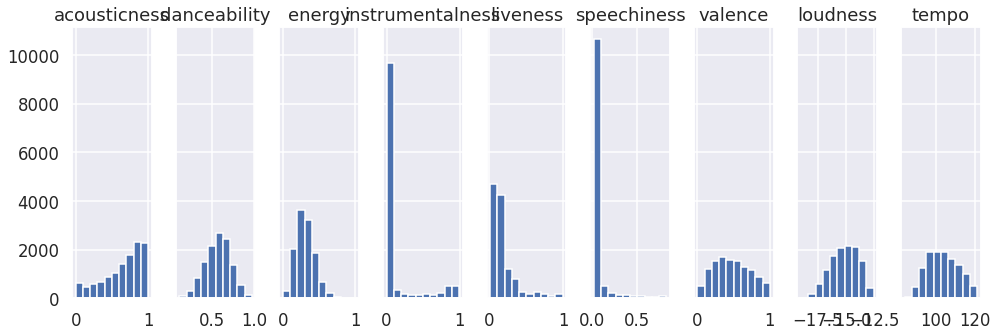

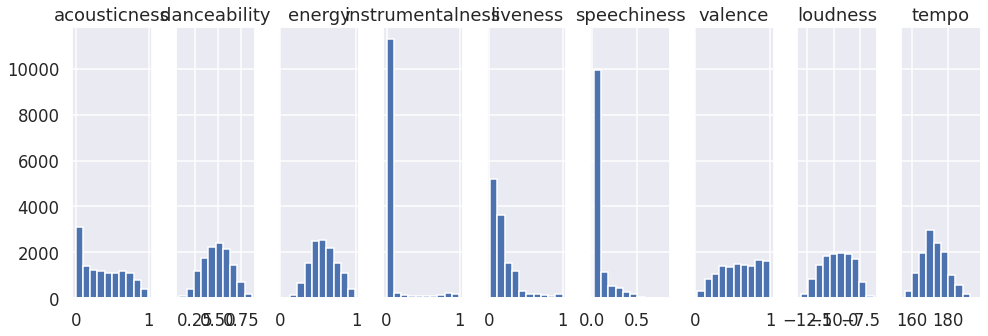

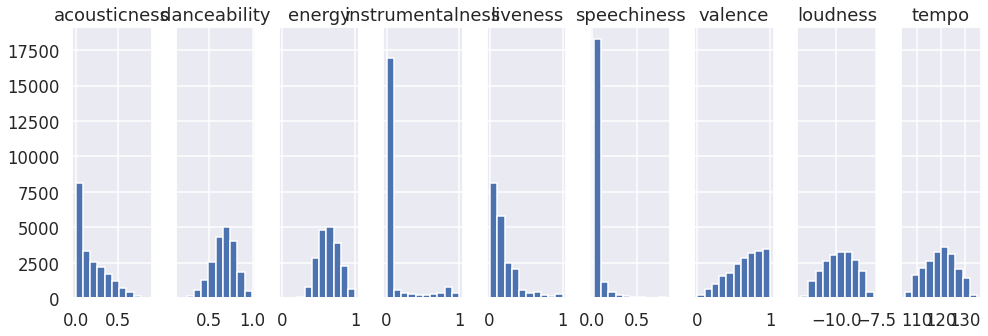

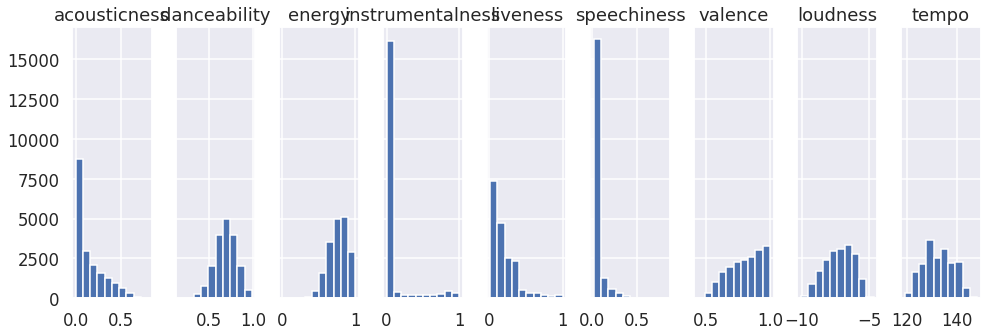

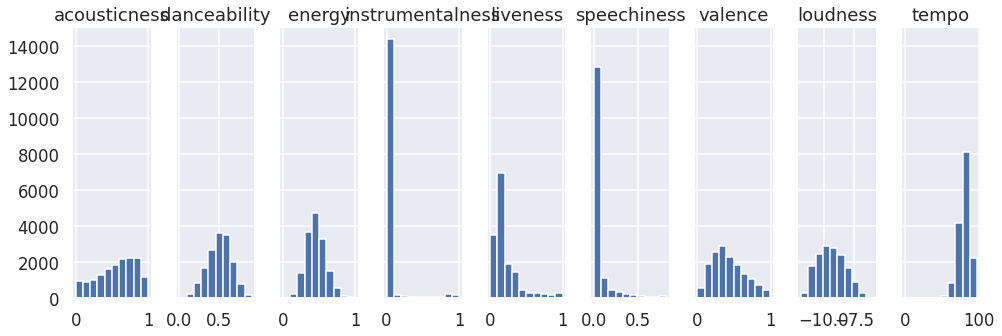

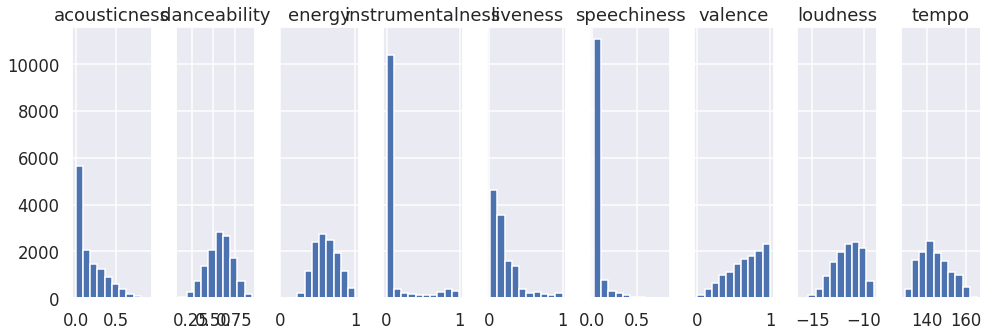

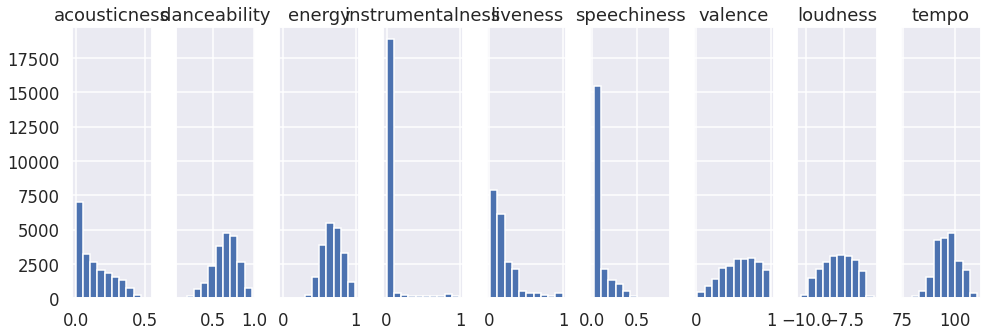

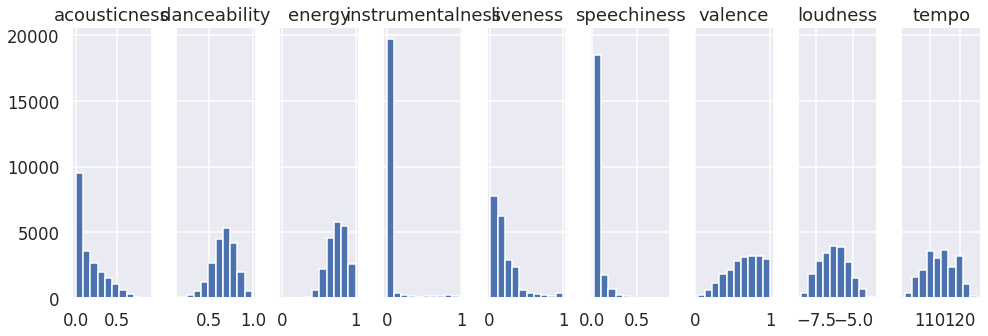

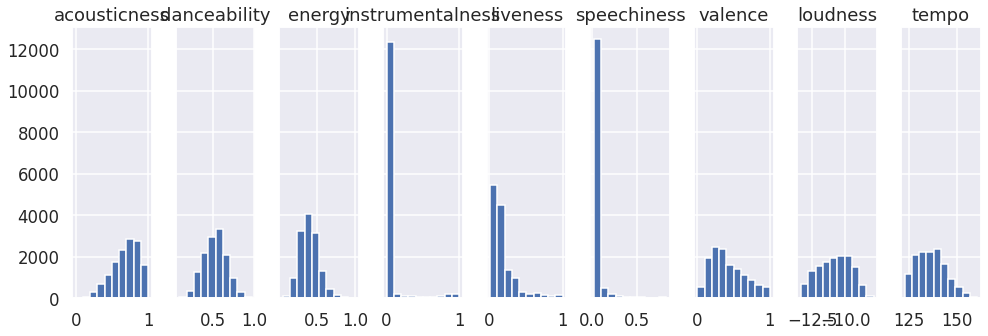

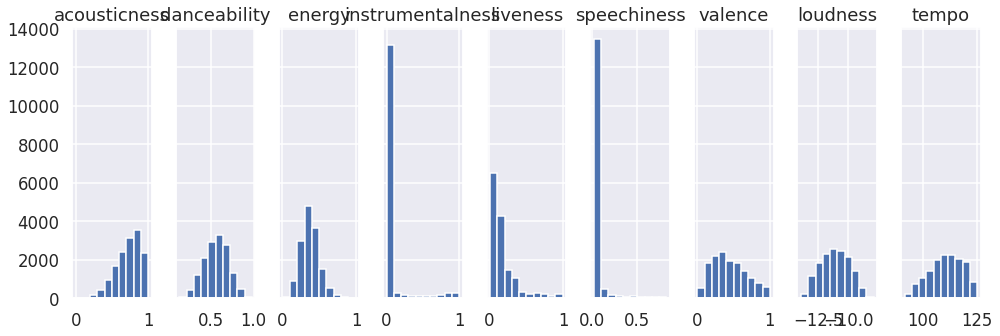

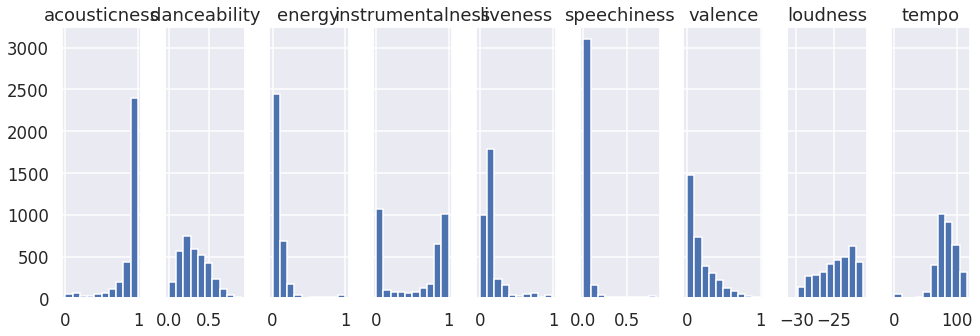

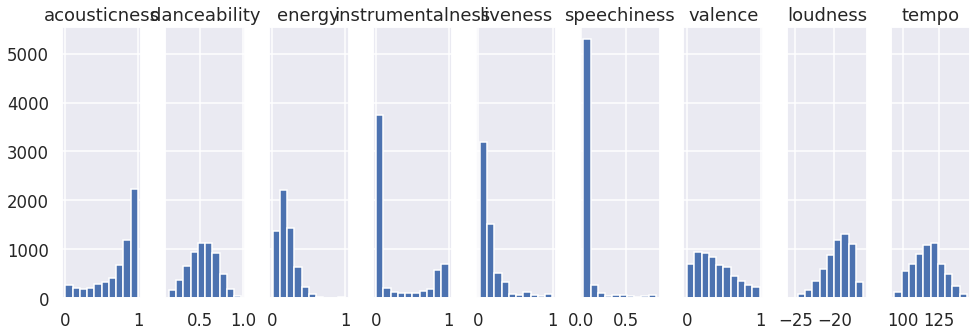

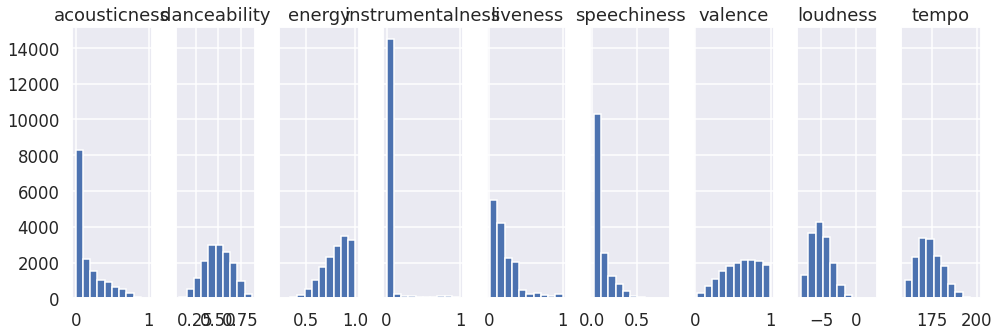

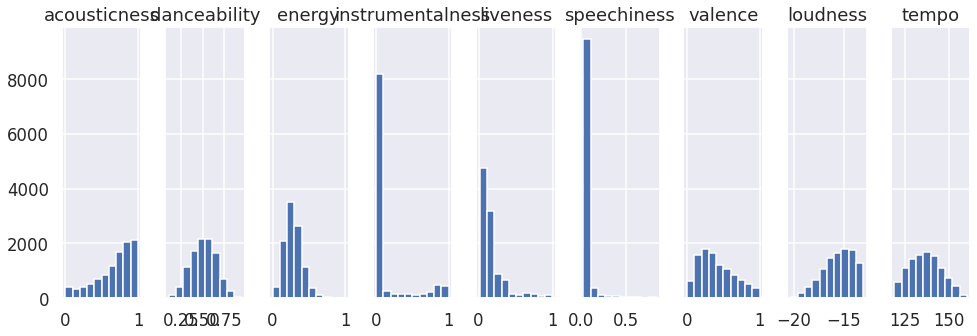

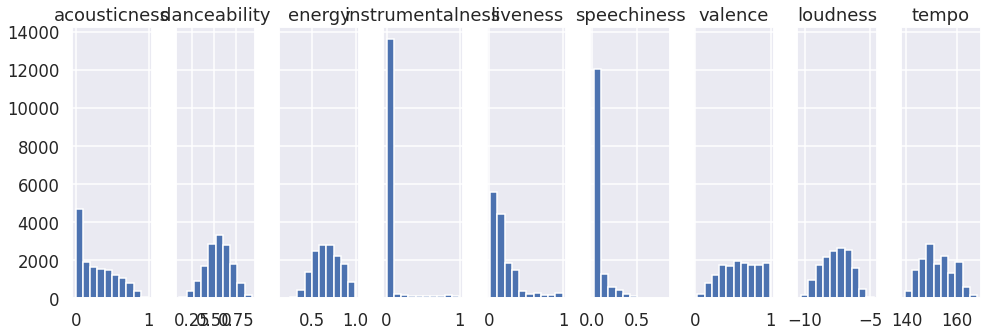

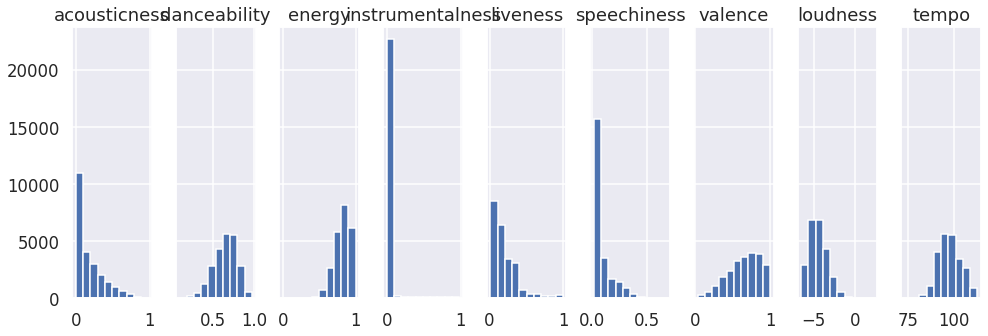

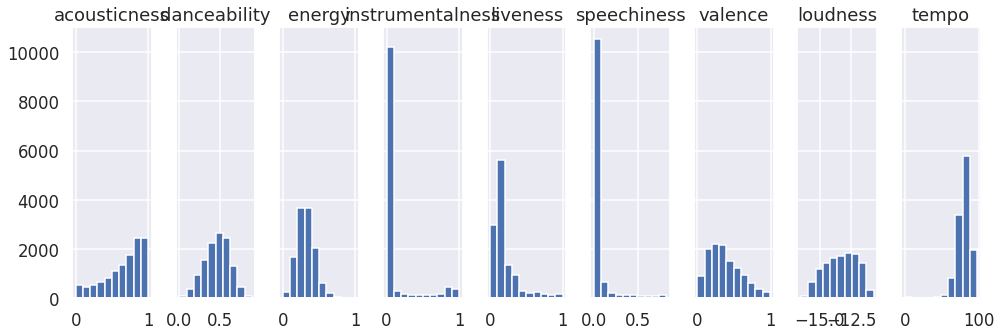

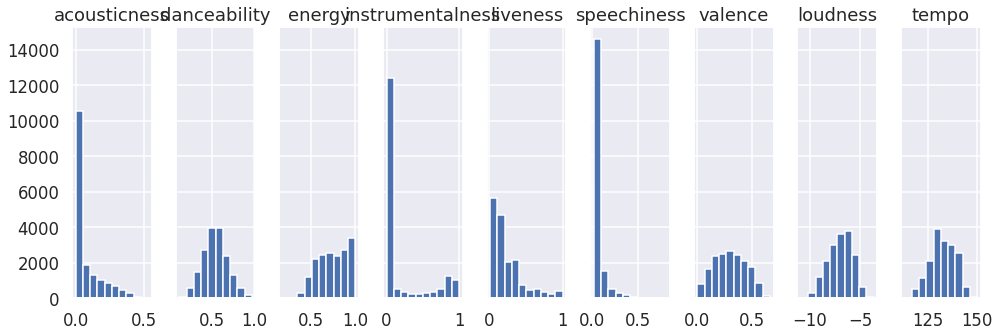

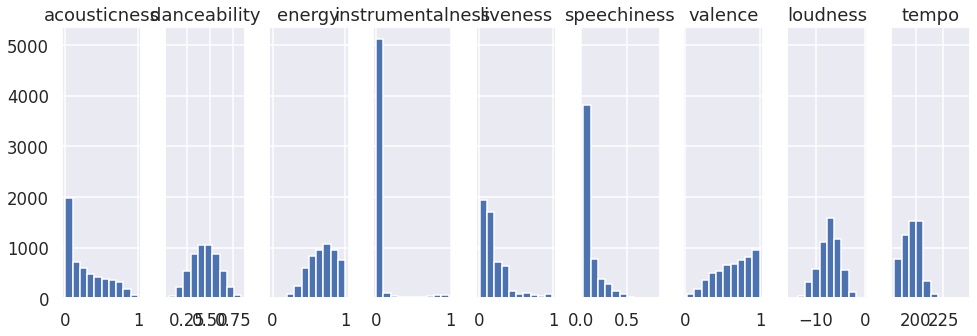

In [ ]:
# 30 clusters -- on only songs from 1970s onwards
y_kmeans30 = kmeans_predict(30)
data['cluster'] = y_kmeans30
output_to_drive(data, 'new_data_30')

Ulimately, the K Means Clustering with 30 clusters best categorized the 600k songs based on its audio features. These 30 clusters will now be further processed and labeled with a corresponding mood/emotion.